In [ ]:
%matplotlib inline

# from diffpy.structure import Atom, Lattice, Structure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from orix import io, plot
from orix.crystal_map import Phase
# from orix.sampling import sample_S2
from orix.vector import Miller, Vector3d
# from orix.crystal_map import CrystalMap, Phase, PhaseList
# from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d
import kikuchipy as kp
import os
from tqdm import tqdm
from visualize_grid import read_data, set_ROI, set_component
from data_processing import get_region_element_averages, get_components, coord_phase_dict_from_dataframe
from cNMF import set_global_determinism, run_cNMF, plot_weight_map_cnmf_with_anomalies, reconstruct_weighted_signals, run_cNMF_with_eds, plot_weight_histograms, plot_weight_sum_histogram, get_intersection_points_y, get_intersection_points_x, get_weight_map, find_all_intersections_xy
from process_indexing_data import plot_phase_heatmap, normalize_misorientation_by_phase_map, plot_element_vs_pca, plot_kam_with_learning_boundary
from PCA import run_PCA, _plot_pca, detect_anomalies_pca, plot_weight_map_pca, plot_explained_variance, reconstruct_pca_signals, plot_pca_comparisons, plot_pca_components_heatmaps, plot_pca_scores_maps
from cluster_analysis import gmm_clustering, plot_cluster_heatmap, calculate_cluster_metrics,plot_intra_cluster_variation_map,plot_cnmf_scatter_with_boundary, plot_gmm_clusters, evaluate_clustering_metrics, plot_cluster_distances_ranking, find_best_reference_window, plot_cnmf_weights_projected
from grid_search_component import optimize_paired_components, visualize_results

# from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# plt.rcParams.update({"figure.figsize": (7, 7), "font.size": 15})
# w, h = plt.rcParams["figure.figsize"]
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
set_global_determinism(seed=42, use_cuda=False)

x dimensions 495 
 y dimensions 266 
 in multiples of 1


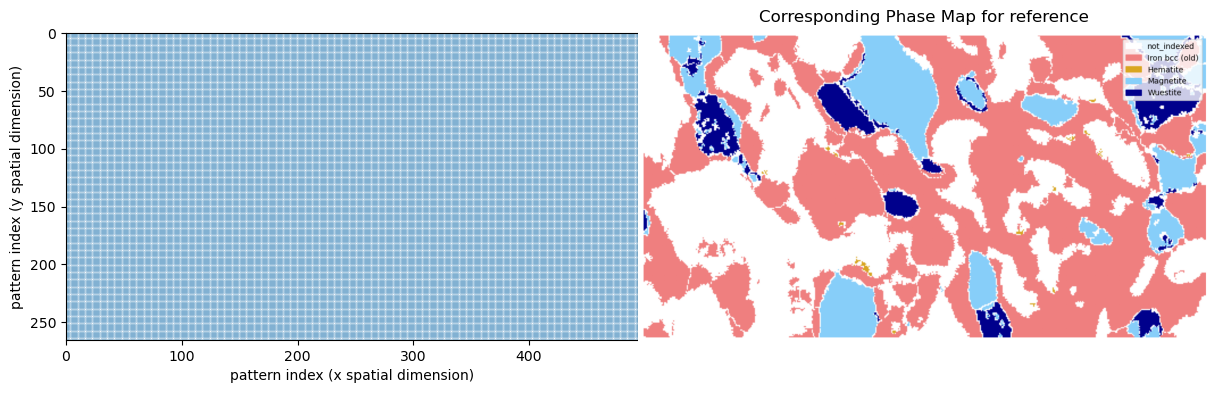

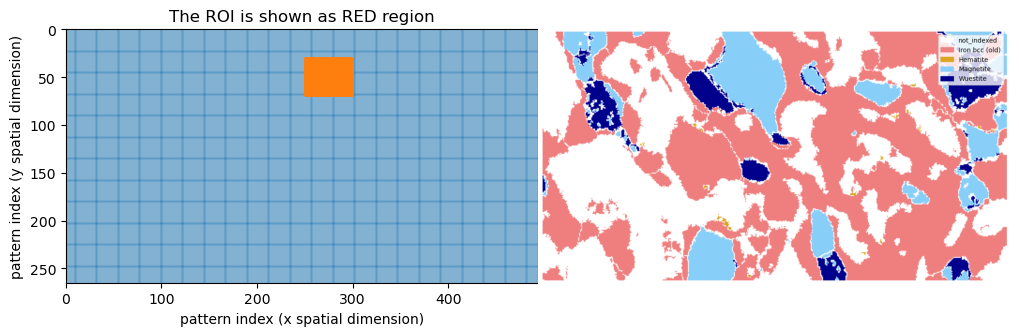

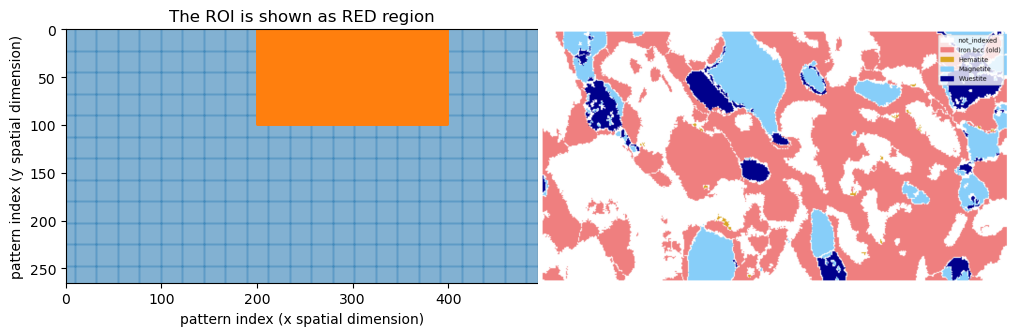

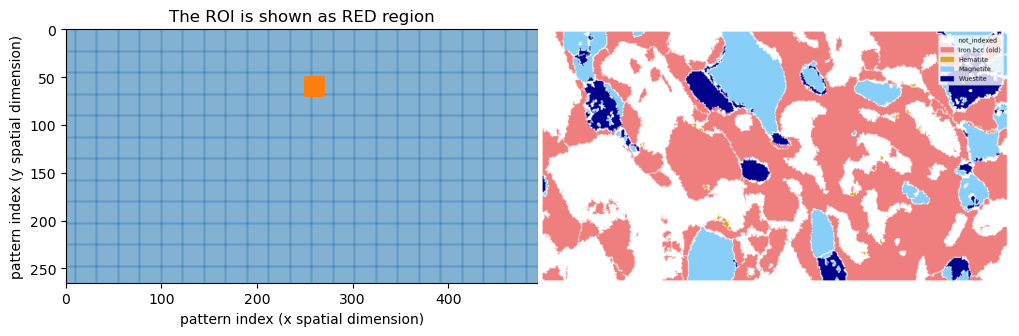

In [23]:
#=== RoI ===
# path = "/home/users/zhangqn8/storage/Partially reduced oxides 20 minutes Arbeitsbereich 3 Elementverteilungsdaten 5/Images_Valid/"
path = "/Volumes/T7/ebsd_data/Images_Valid/"
path_to_phase_map = "/Volumes/T7/phase_map.png"
# path_to_phase_map = "phase_map.png"
grid = read_data(path, path_to_phase_map)

#kikuchi pattern args
height= 512
width = 672
slice_x = (86,586)
slice_y = (56,456)


roi_xrange_x1 = (250,300)
roi_yrange_x1 = (30,70)
X1, loc_1 = set_ROI(roi_xrange_x1,roi_yrange_x1, path, grid, path_to_phase_map)

roi_xrange_x2 = (200,400)
roi_yrange_x2 = (0,100)
X2, loc_2 = set_ROI(roi_xrange_x2,roi_yrange_x2, path, grid, path_to_phase_map)


roi_xrange_x3 = (250,270)
roi_yrange_x3 = (50,70)
X3, loc_3 = set_ROI(roi_xrange_x3,roi_yrange_x3, path, grid, path_to_phase_map)
#===software results===
df = pd.read_csv("/Volumes/T7/ebsd_processed_with_grain_boundary.csv")
# df = pd.read_csv("ebsd_processed_with_grain_boundary.csv")

# coordinates: phase_id
coord_phase_dict = coord_phase_dict_from_dataframe(df, True)

/opt/anaconda3/envs/kp/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2/2 [00:00<00:00, 1442.08it/s]


[GMM] selection=hybrid -> k=3 | BIC=678763.2 AIC=592218.1 SIL=0.2855


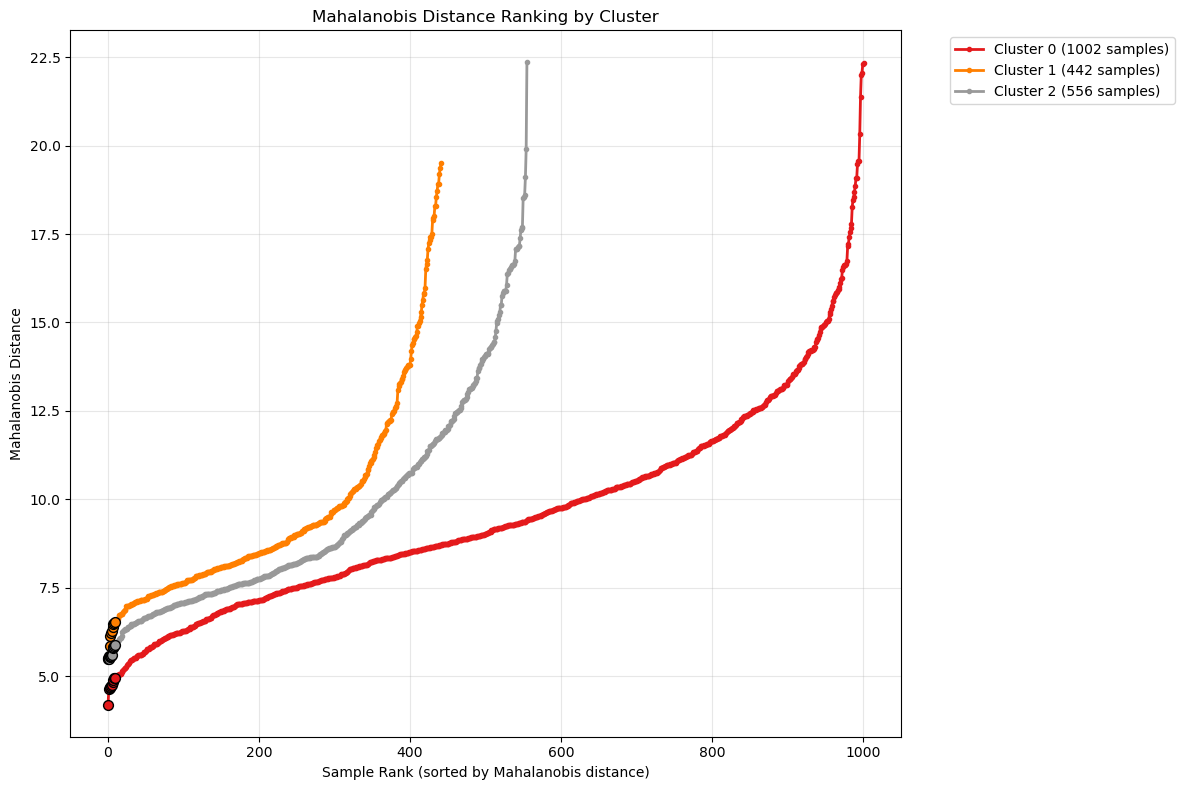

Top samples per cluster:
Cluster 0: 10 samples
  Distance range: 4.1976 - 4.9606
  Coordinates: [[296  52]
 [286  55]
 [296  60]]...

Cluster 1: 10 samples
  Distance range: 5.5059 - 6.5421
  Coordinates: [[275  67]
 [279  66]
 [278  65]]...

Cluster 2: 10 samples
  Distance range: 5.4803 - 5.8896
  Coordinates: [[269  32]
 [271  43]
 [267  37]]...

Best Reference Windows per Cluster:
Cluster 0:
  Center Location: [287  45]
  Metric Value: 7.0022 (w1=1, w2=1)
  Window Mean Distance: 6.1937
  Window Variance: 0.8085
----------------------------------------
Cluster 1:
  Center Location: [272  64]
  Metric Value: 7.3432 (w1=1, w2=1)
  Window Mean Distance: 7.1426
  Window Variance: 0.2006
----------------------------------------
Cluster 2:
  Center Location: [267  37]
  Metric Value: 6.6985 (w1=1, w2=1)
  Window Mean Distance: 6.4072
  Window Variance: 0.2913
----------------------------------------


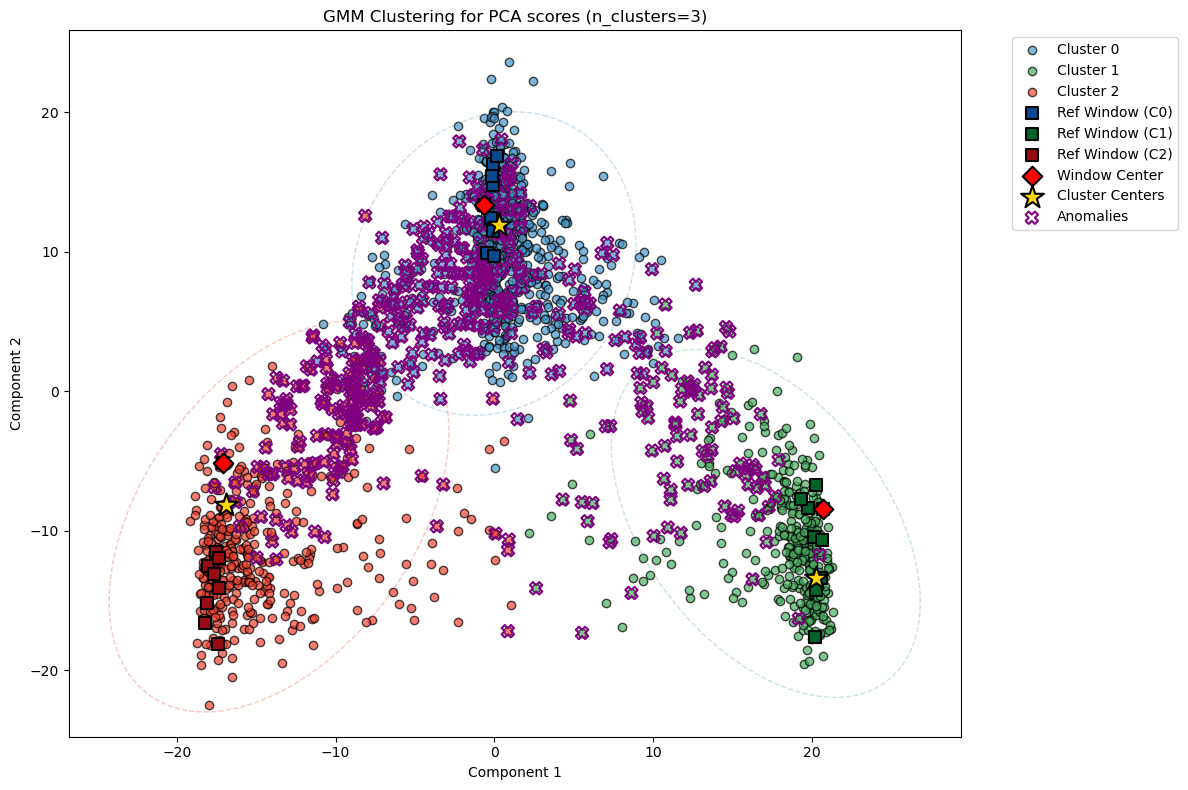

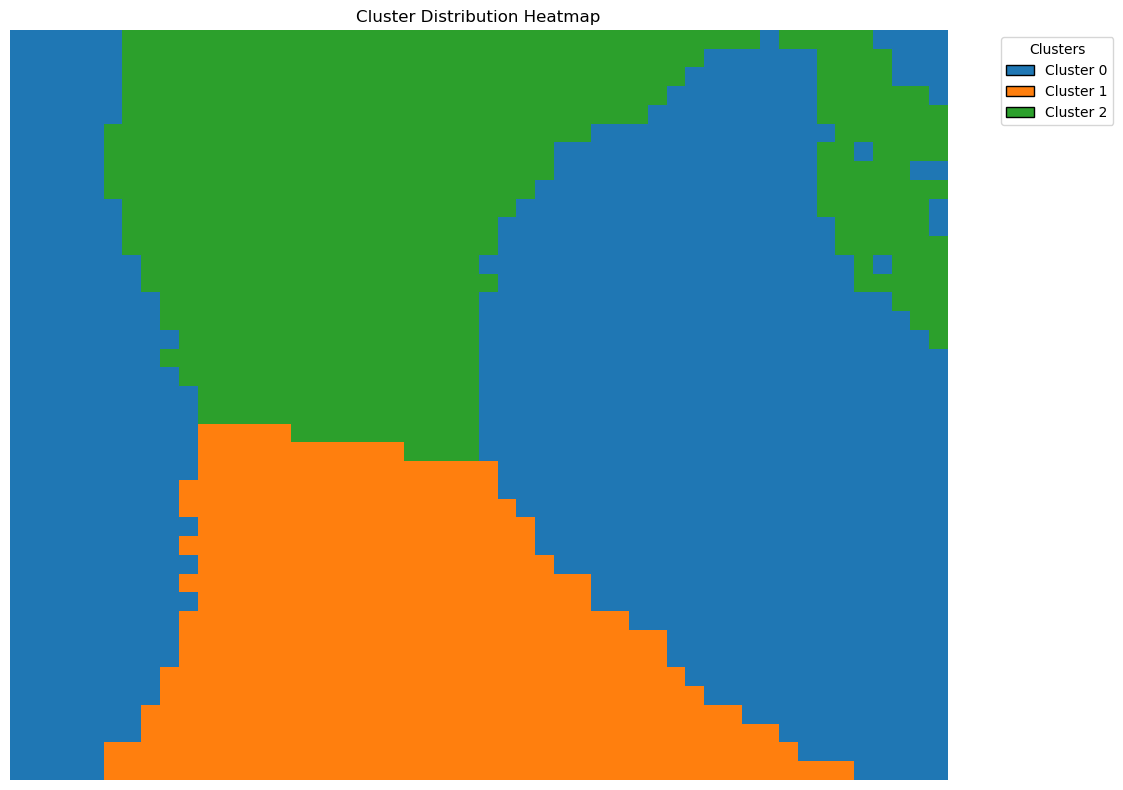

In [3]:
pca_scores1, pca1 = run_PCA(X1, 100 ,height, width,slice_x, slice_y)
gmm_model1, cluster_coords_1, coord_to_label1, cluster_label1, optimal_n, silhouette = gmm_clustering(pca_scores1, loc_1, None, 10)

#anomalies_cluster_pca_scores1, anomalies_cluster_pca_coords1, anomalies_labels_pca1 = detect_anomalies_pca(pca_scores, coord_to_label1, loc_relative)
anomalies_cluster_pca_scores1, anomalies_cluster_pca_coords1, anomalies_coords_label1 = detect_anomalies_pca(pca_scores1, coord_to_label1, loc_1)
centers1, covs1, variations1 = calculate_cluster_metrics(gmm_model1, cluster_label1, pca_scores1)

top_samples_per_cluster= plot_cluster_distances_ranking(gmm_model1, cluster_label1, pca_scores1, loc_1)
best_window = find_best_reference_window(top_samples_per_cluster, cluster_label1, variations1, loc_1)

plot_gmm_clusters(pca_scores1, cluster_label1, optimal_n, variations1, 2, anomalies_cluster_pca_scores1, best_window)

plot_cluster_heatmap(cluster_coords_1,(40,50))

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
         Metric         Value
            ARI      0.363242
            NMI      0.478576
    homogeneity      0.466941
   completeness      0.490805
      v_measure      0.478576
mapped_accuracy        0.8055
   mapping_mode Majority-vote
  user_accuracy          None

Cluster-to-Phase Mapping (Majority-vote):
------------------------------------------------------------
 cluster  Samples User mapping Chosen mapping
       0     1002            —      Magnetite
       1      442            — Iron bcc (old)
       2      556            — Iron bcc (old)

Confusion Matrix (After Mapping):
------------------------------------------------------------
                      Pred: not_indexed  Pred: Iron bcc (old)  \
True: not_indexed                     0                    22   
True: Iron bcc (old)                  0                   973   
True: Magnetite                       0

/Users/kikizhang/Phd/Workflow/pycode/microstructural_segmentation/cluster_analysis.py:738: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


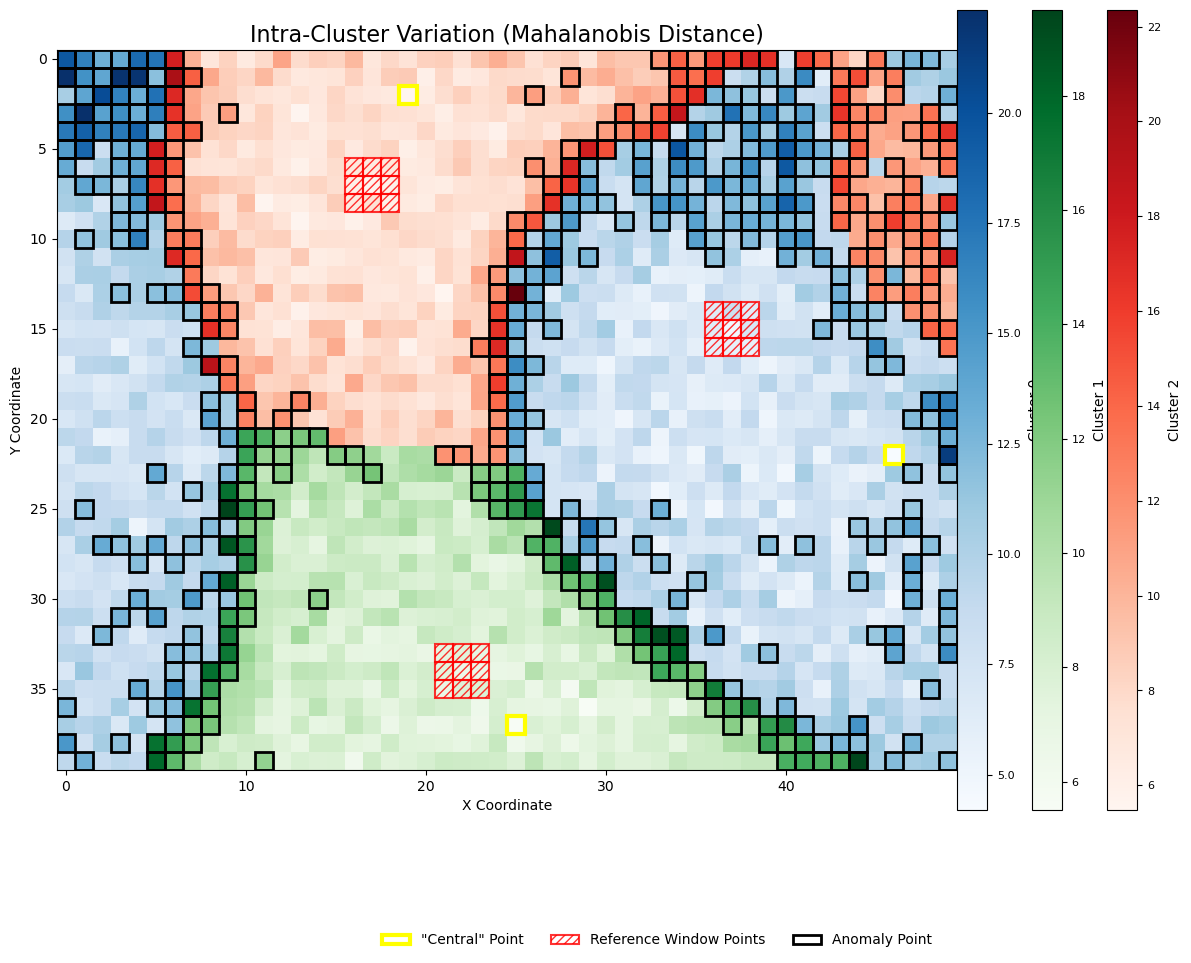

In [4]:
phase_labels = {
    -1: 'not_indexed',
     1: 'Iron bcc (old)',
     3: 'Hematite',
     4: 'Magnetite',
     5: 'Wuestite'
}
evaluate_results = evaluate_clustering_metrics(coord_phase_dict, coord_to_label1, phase_labels, None, True, "majority")
mapped_phaseid= evaluate_results['detailed_results']['mapped_phaseid']
plot_intra_cluster_variation_map(loc_1, variations1, cluster_label1, (40,50), None, None, anomalies_cluster_pca_coords1, None, None, best_window)

[########################################] | 100% Completed | 104.39 ms


100%|██████████| 2/2 [00:00<00:00, 89.58it/s]

[########################################] | 100% Completed | 105.82 ms



100%|██████████| 2/2 [00:00<00:00, 111.64it/s]

[########################################] | 100% Completed | 104.83 ms



100%|██████████| 2/2 [00:00<00:00, 131.81it/s]


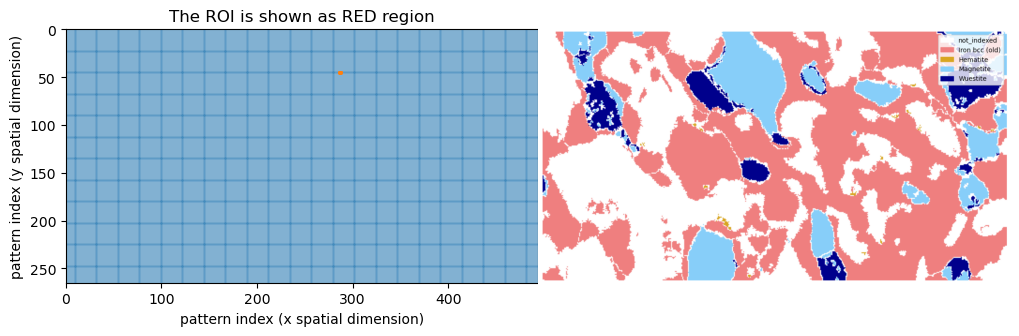

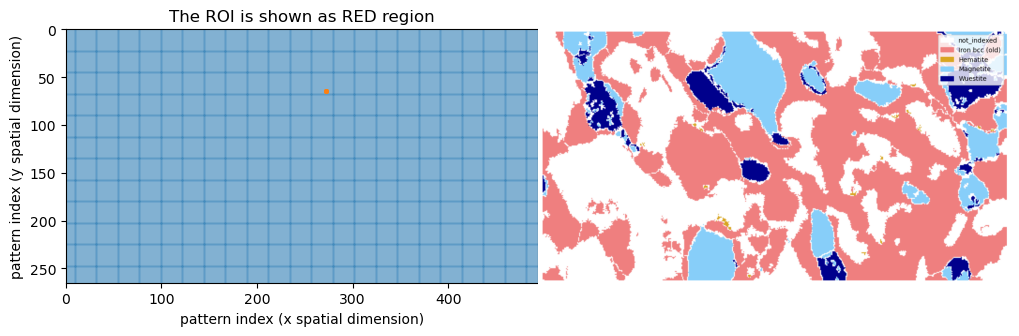

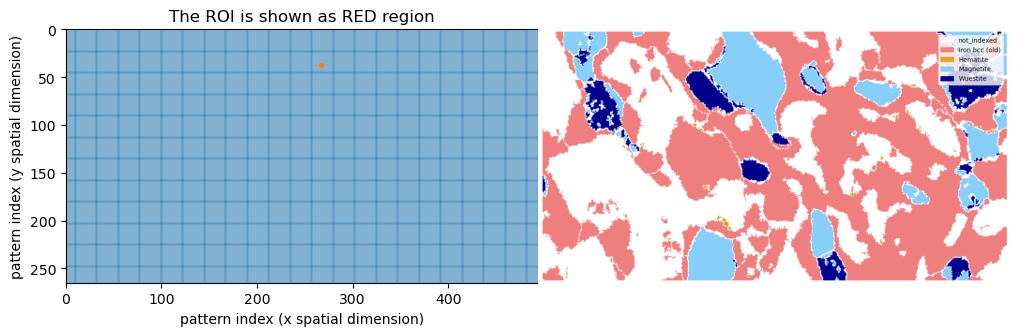

In [5]:
R_list = []
ranges_list = []   # [(x_range, y_range, center_loc, key), ...]
ref_pos_list = []

# Sorted iteration for reproducibility
for key in sorted(best_window.keys(), key=lambda k: int(k)):
    entry = best_window[key]
    cx, cy = map(int, entry['center_loc'])  # center_loc: array([x, y])

    x0, x1 = cx - 1, cx + 1
    y0, y1 = cy - 1, cy + 1

    
    x_range = (x0, x1)
    y_range = (y0, y1)

    R, ref_pos = set_component(x_range, y_range, path, grid, path_to_phase_map)

    R_list.append(R)
    ref_pos_list.append(ref_pos)
    ranges_list.append((x_range, y_range, (cx, cy), int(key)))

# Build final components object
components = get_components(R_list, 3, None, height, width, slice_x, slice_y)

In [6]:
# run cNMF
weights1,mse,r_square = run_cNMF(X1, components, height, width, slice_x, slice_y)

# Sum of all weights
row_sums_minus_1 = weights1.sum(axis=1) - 1
abs_values = np.abs(row_sums_minus_1)

# Min and Max for the sum -1
max_abs = np.max(abs_values)
min_abs = np.min(abs_values)
max_abs_index = np.argmax(abs_values)
min_abs_index = np.argmin(abs_values)

print(f"Max absolute value of (weight sum-1): {max_abs} (In row {max_abs_index})")
print(f"Min absolute value of (weight sum-1): {min_abs} (In row {min_abs_index})")

100%|██████████| 2/2 [00:00<00:00, 1212.75it/s]


Max absolute value of (weight sum-1): 0.36288249492645264 (In row 100)
Min absolute value of (weight sum-1): 0.07856857776641846 (In row 1815)


[GMM] fixed k=3 | SIL=0.5726


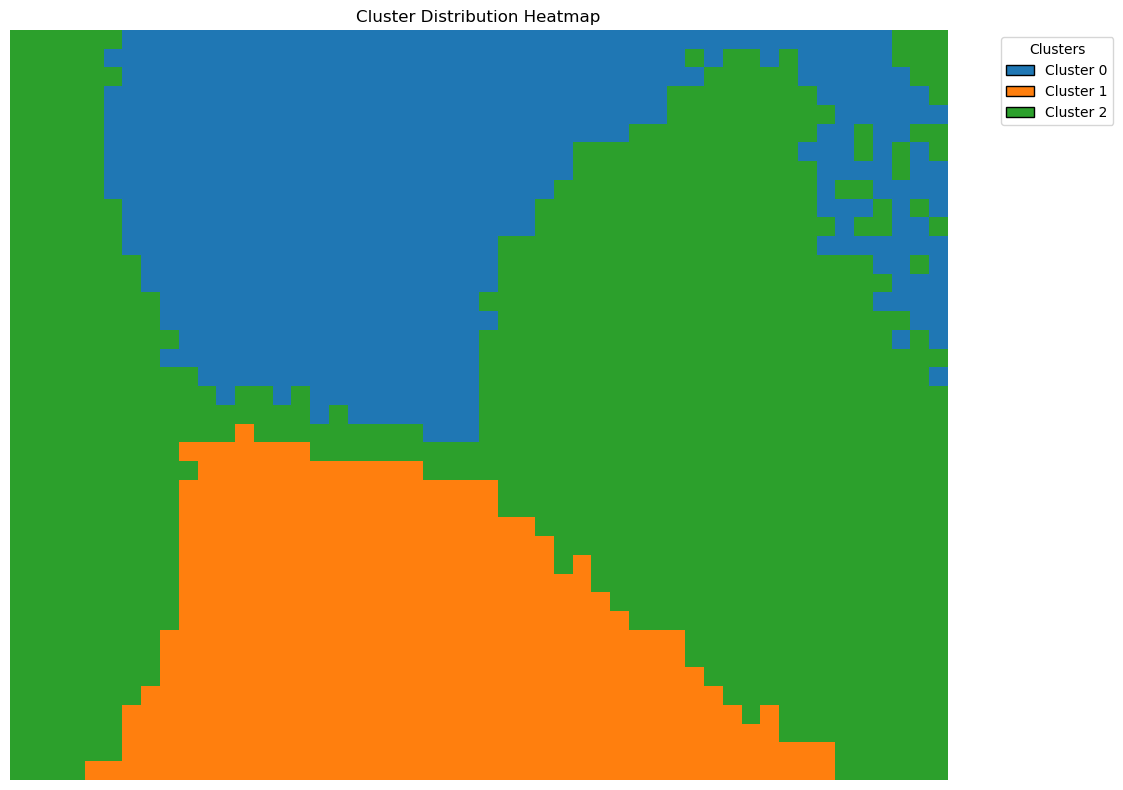

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
         Metric         Value
            ARI      0.327974
            NMI      0.425419
    homogeneity      0.414868
   completeness       0.43652
      v_measure      0.425419
mapped_accuracy        0.7905
   mapping_mode Majority-vote
  user_accuracy          None

Cluster-to-Phase Mapping (Majority-vote):
------------------------------------------------------------
 cluster  Samples User mapping Chosen mapping
       0      547            — Iron bcc (old)
       1      446            — Iron bcc (old)
       2     1007            —      Magnetite

Confusion Matrix (After Mapping):
------------------------------------------------------------
                      Pred: not_indexed  Pred: Iron bcc (old)  \
True: not_indexed                     0                    40   
True: Iron bcc (old)                  0                   946   
True: Magnetite                       0

In [16]:
gmm_model_cnmf1, cluster_coords_cnmf1, coord_to_label_cnmf1, cluster_labels_cnmf1, optimal_n, silhouette = gmm_clustering(weights1, loc_1, 3, 10)

plot_cluster_heatmap(cluster_coords_cnmf1,(40,50))

evaluate_results = evaluate_clustering_metrics(coord_phase_dict, coord_to_label_cnmf1, phase_labels, None, True)
cluster_name_map = evaluate_results['mapping_names']

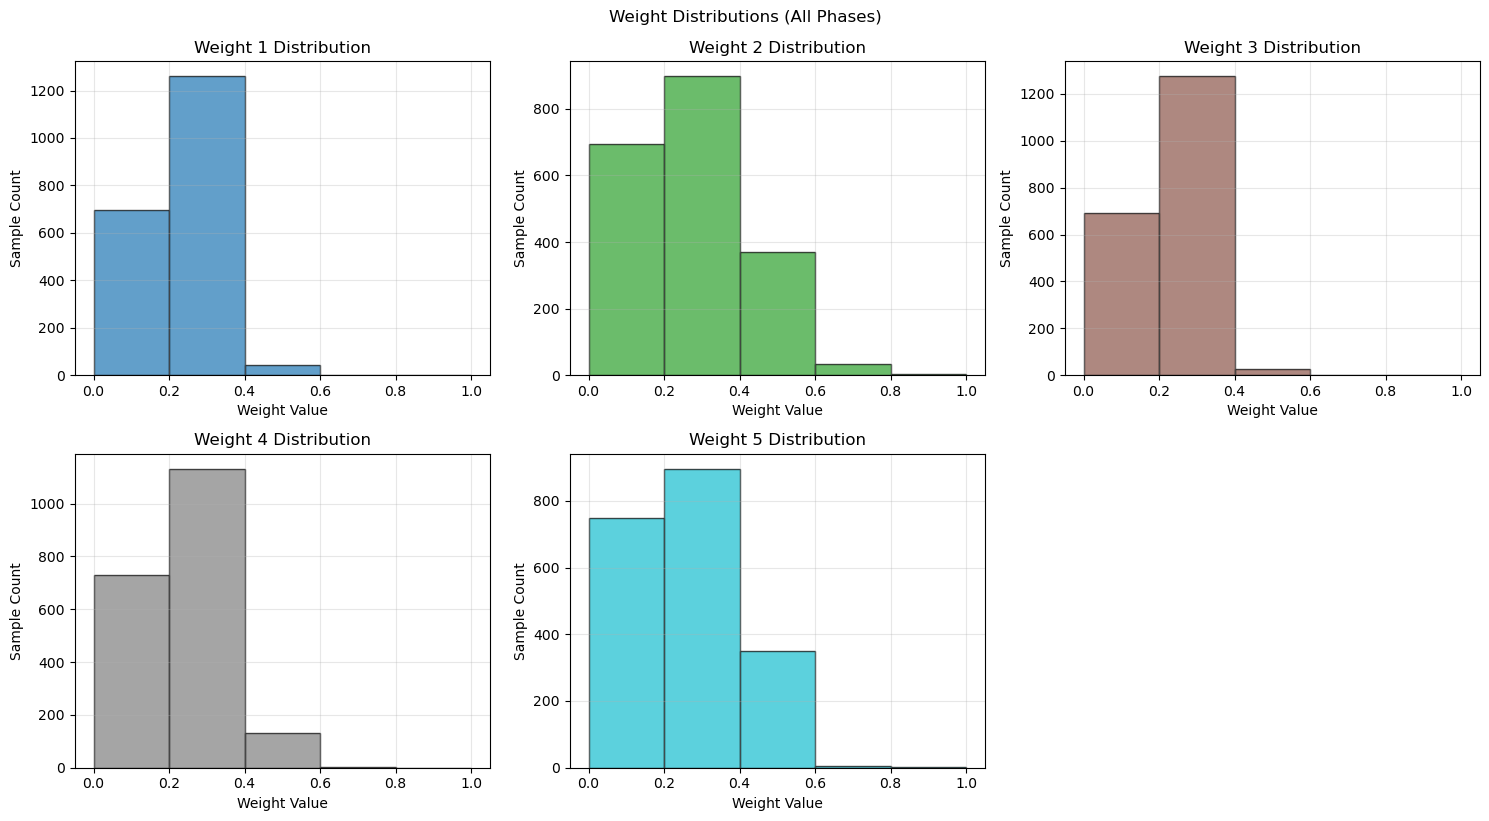

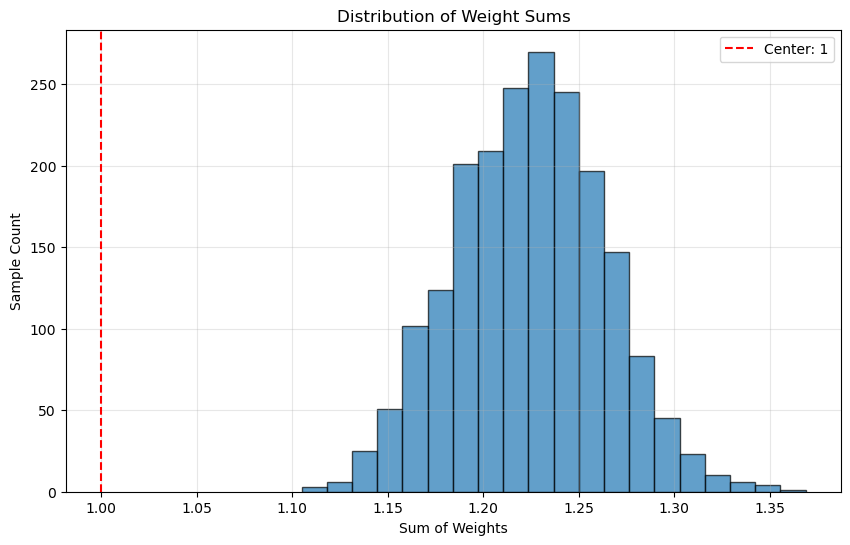

In [17]:
plot_weight_histograms(weights1, loc_1, coord_to_label_cnmf1, cluster_name_map, None, None)
plot_weight_sum_histogram(weights1, 1, 20)

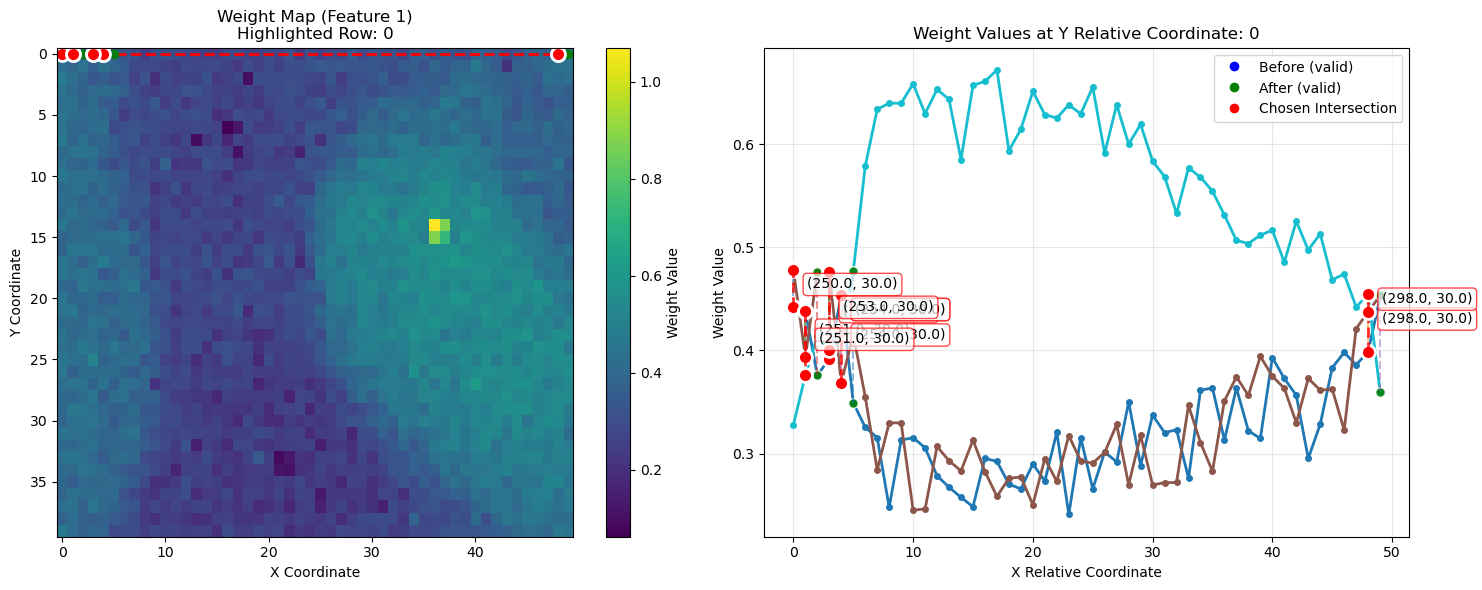

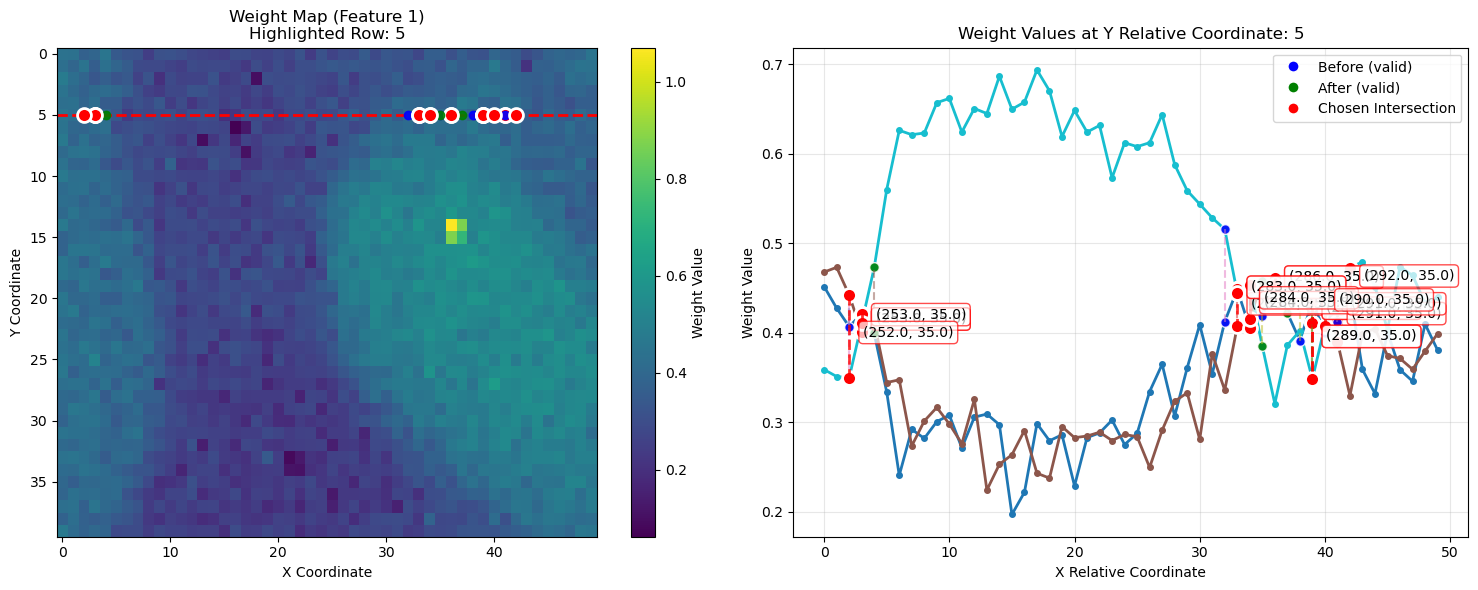

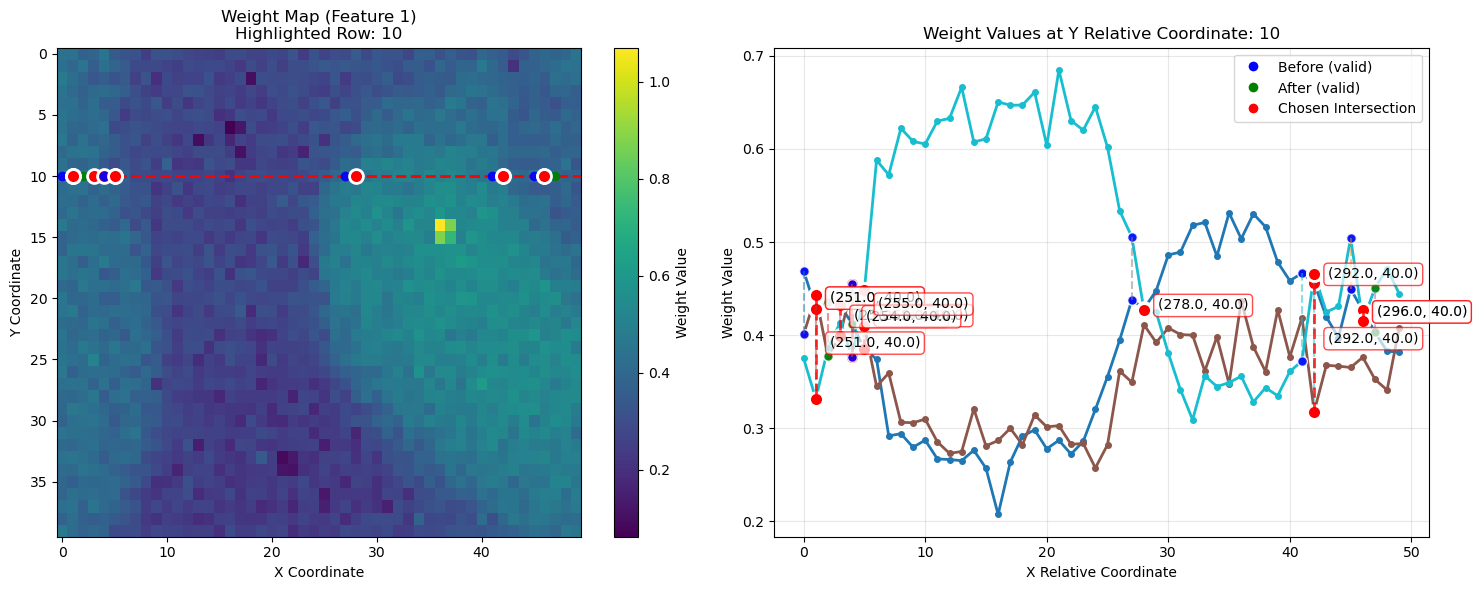

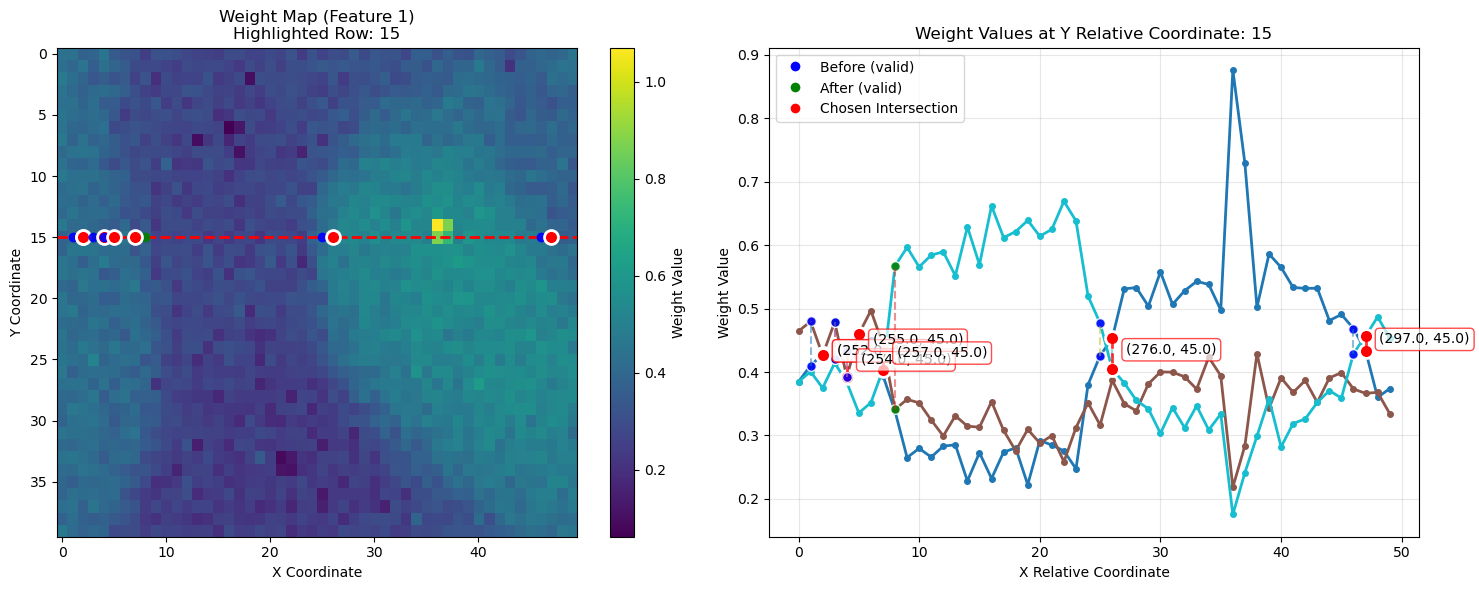

In [7]:
weight_maps = get_weight_map(weights1, loc_1, 40, 50)
intersections1, fig1 = get_intersection_points_y(weight_maps, 0, roi_xrange_x1[0], roi_yrange_x1[0], 40, 50)
intersections2, fig2 = get_intersection_points_y(weight_maps, 5, roi_xrange_x1[0], roi_yrange_x1[0], 40, 50)
intersections3, fig3 = get_intersection_points_y(weight_maps, 10, roi_xrange_x1[0], roi_yrange_x1[0], 40, 50)
intersections4, fig4 = get_intersection_points_y(weight_maps, 15, roi_xrange_x1[0], roi_yrange_x1[0], 40, 50)

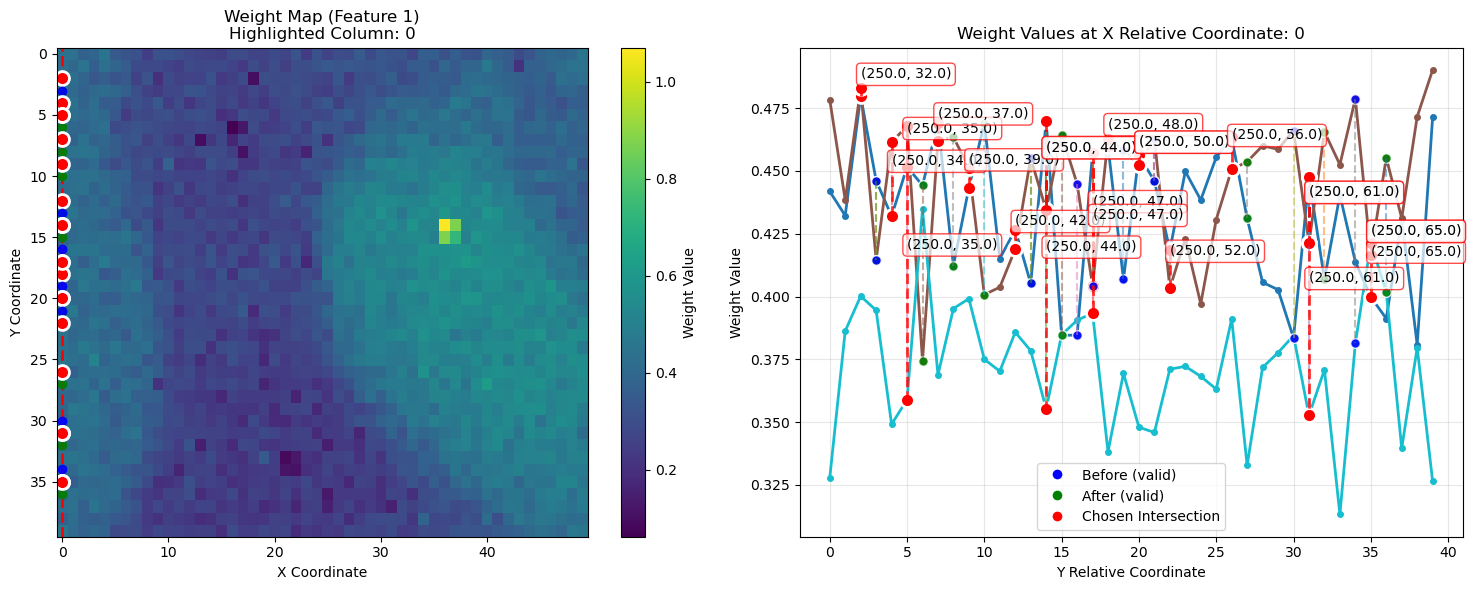

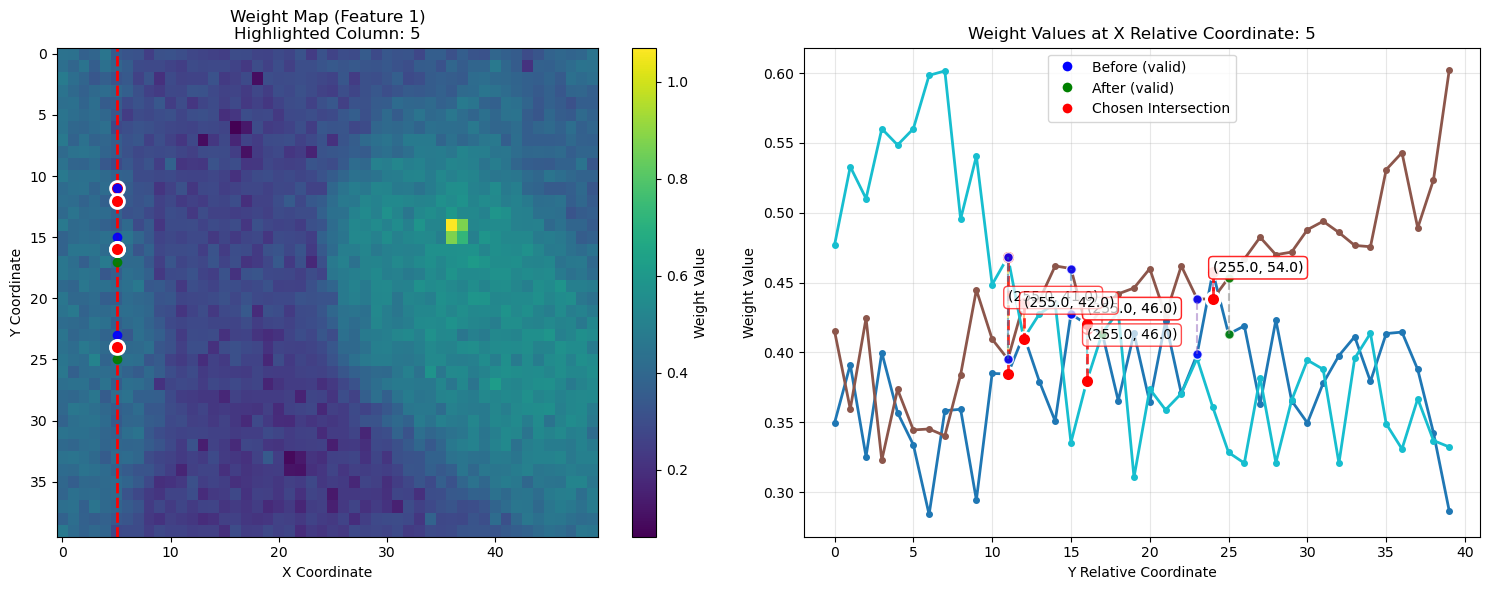

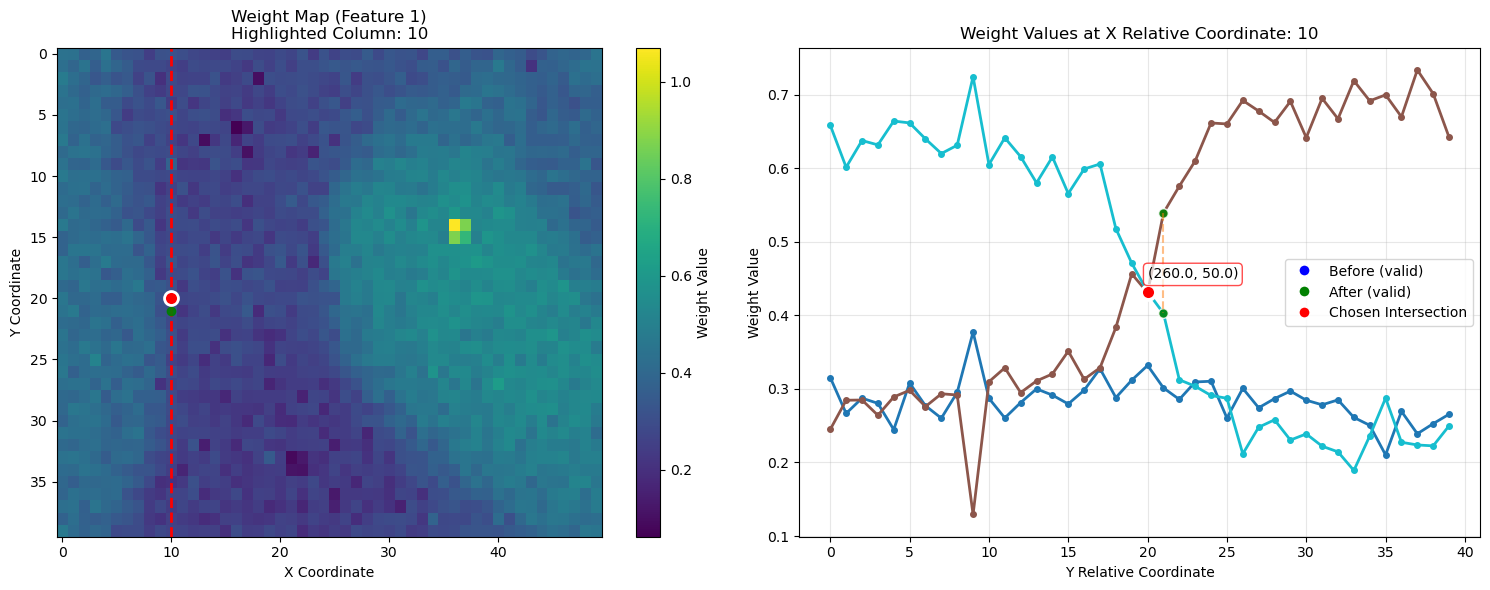

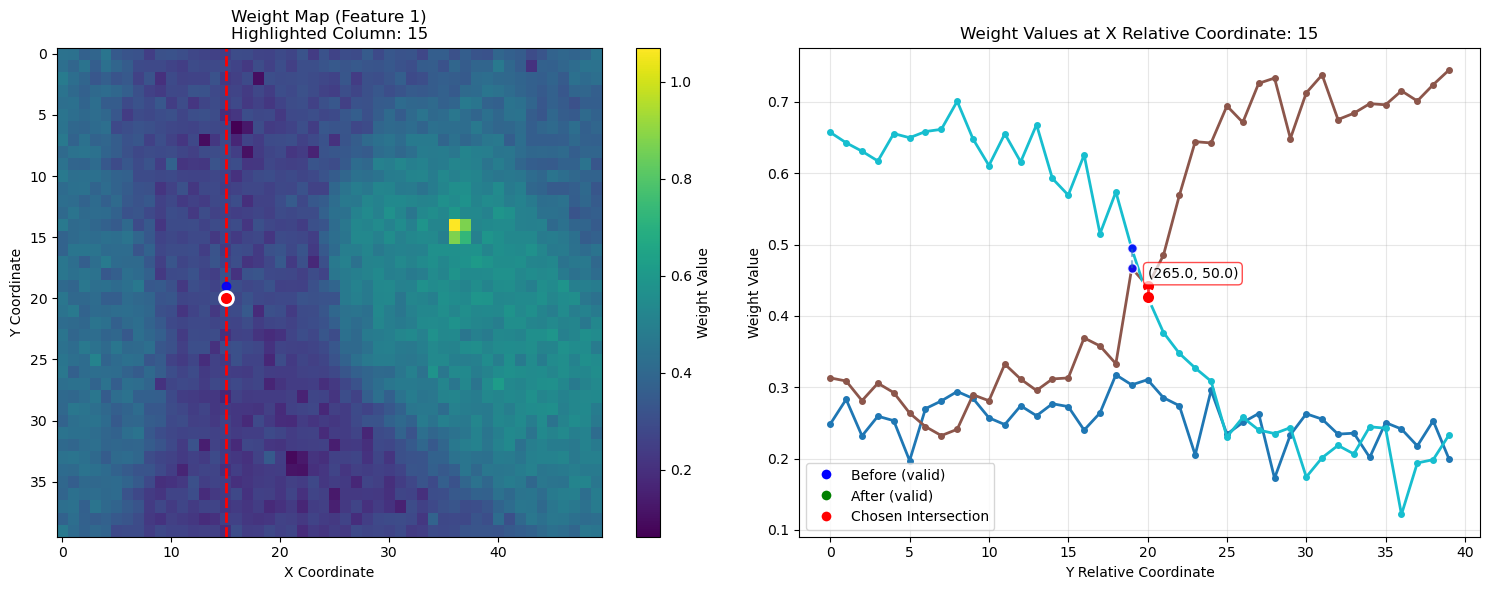

In [8]:
intersections1, fig1 = get_intersection_points_x(weight_maps, 0, roi_xrange_x1[0], roi_yrange_x1[0], 40, 50, require_opposite_slopes=False, exclude_local_extrema=False)
intersections2, fig2 = get_intersection_points_x(weight_maps, 5, roi_xrange_x1[0], roi_yrange_x1[0], 40, 50)
intersections3, fig3 = get_intersection_points_x(weight_maps, 10, roi_xrange_x1[0], roi_yrange_x1[0], 40, 50)
intersections4, fig4 = get_intersection_points_x(weight_maps, 15, roi_xrange_x1[0], roi_yrange_x1[0], 40, 50)

In [9]:
all_intersections = find_all_intersections_xy(weights1, loc_1, 40, 50)

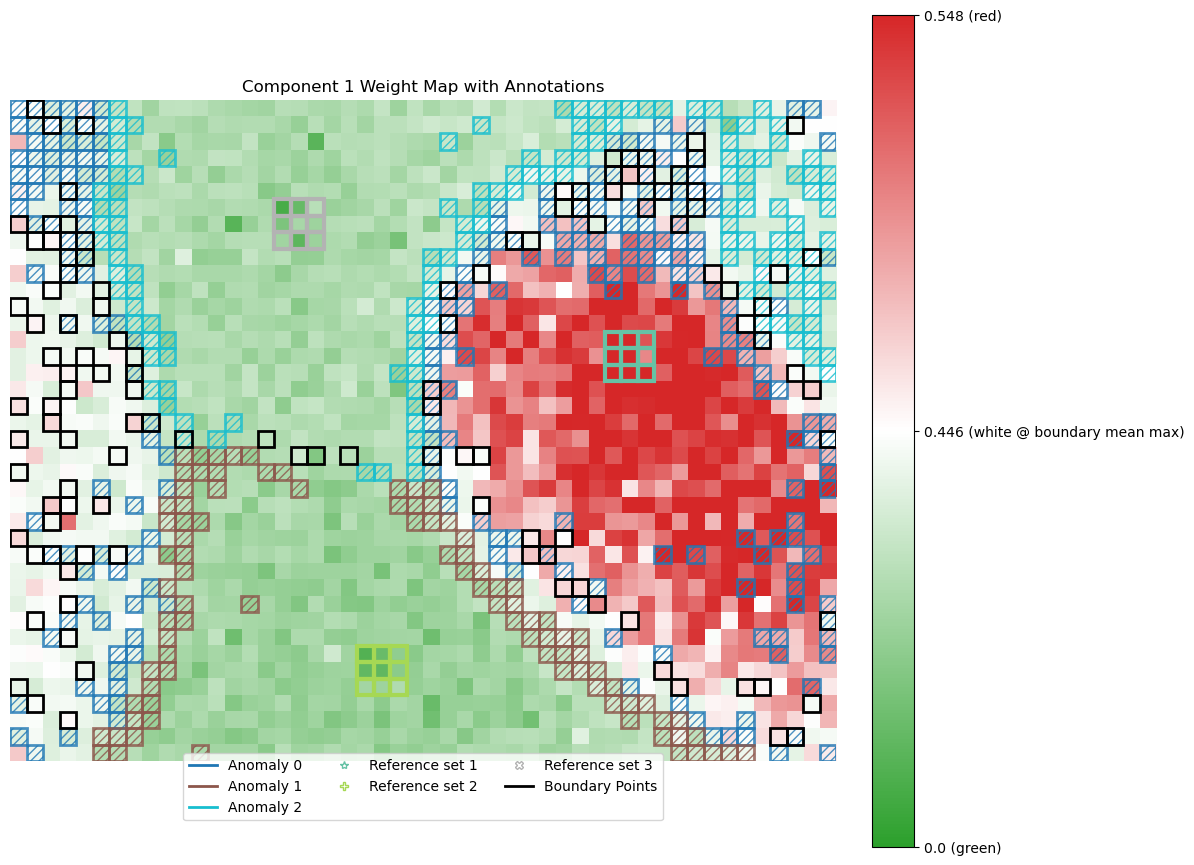

Similarity between anomalies and boundary points:
  Number of anomalies: 469
  Number of boundary points: 118
  Intersection: 40
  Jaccard Index: 0.0731
  Overlap Coefficient: 0.3390


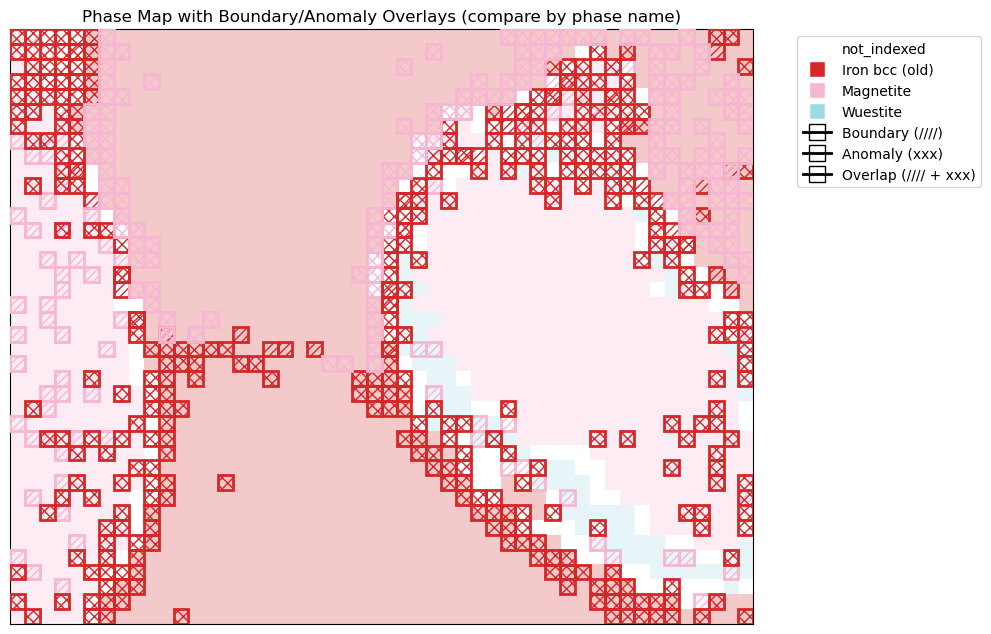

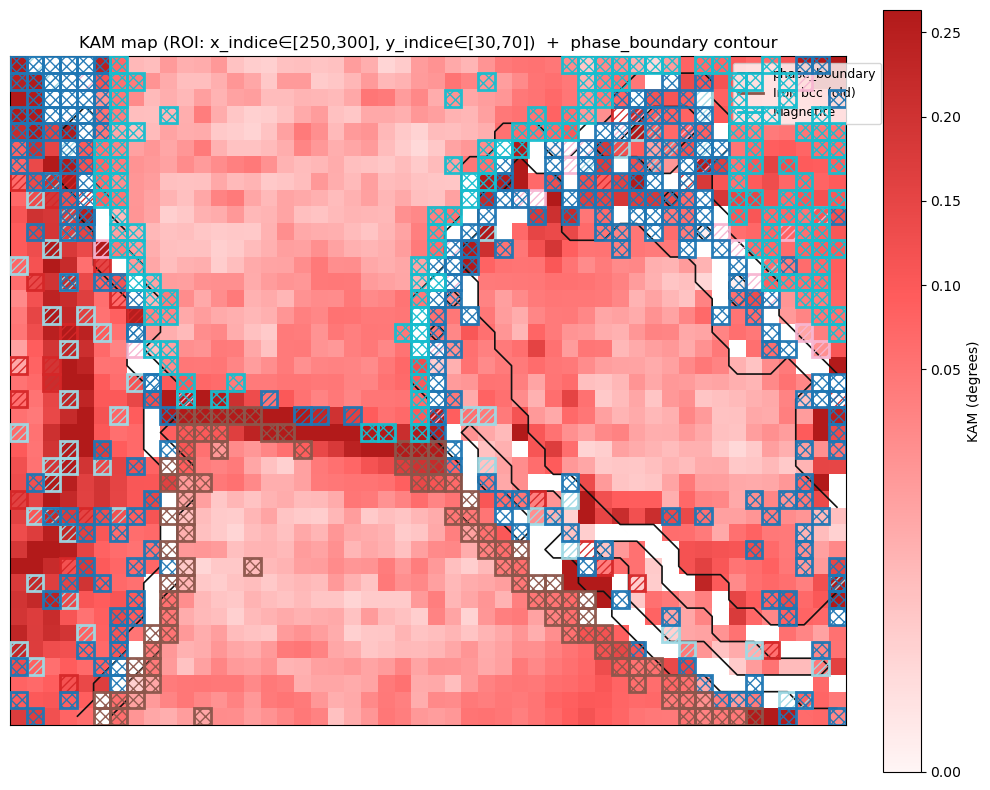

In [14]:
#=== boundary detected both in the direction x and y ====

boundary_pairs = set([(point[0], point[1]) for point in all_intersections['overlapping']])
boundary_label_dict = {coord: coord_to_label_cnmf1[coord] 
                 for coord in boundary_pairs if coord in coord_to_label_cnmf1}
jaccard, overlap_coefficient= plot_weight_map_cnmf_with_anomalies(weights1, loc_1, 40, 50, anomalies_coords_label1,ref_pos_list, 0, boundary_pairs)

plot_phase_heatmap(coord_phase_dict, boundary_label_dict, anomalies_coords_label1, phase_labels, cluster_name_map, cluster_name_map, (40,50), roi_xrange_x1, roi_yrange_x1)

plot_kam_with_learning_boundary(df, "phase_boundary", roi_xrange_x1, roi_yrange_x1, boundary_label_dict, anomalies_coords_label1, cluster_name_map, cluster_name_map, (10,8), "KAM", "x_indice", "y_indice")


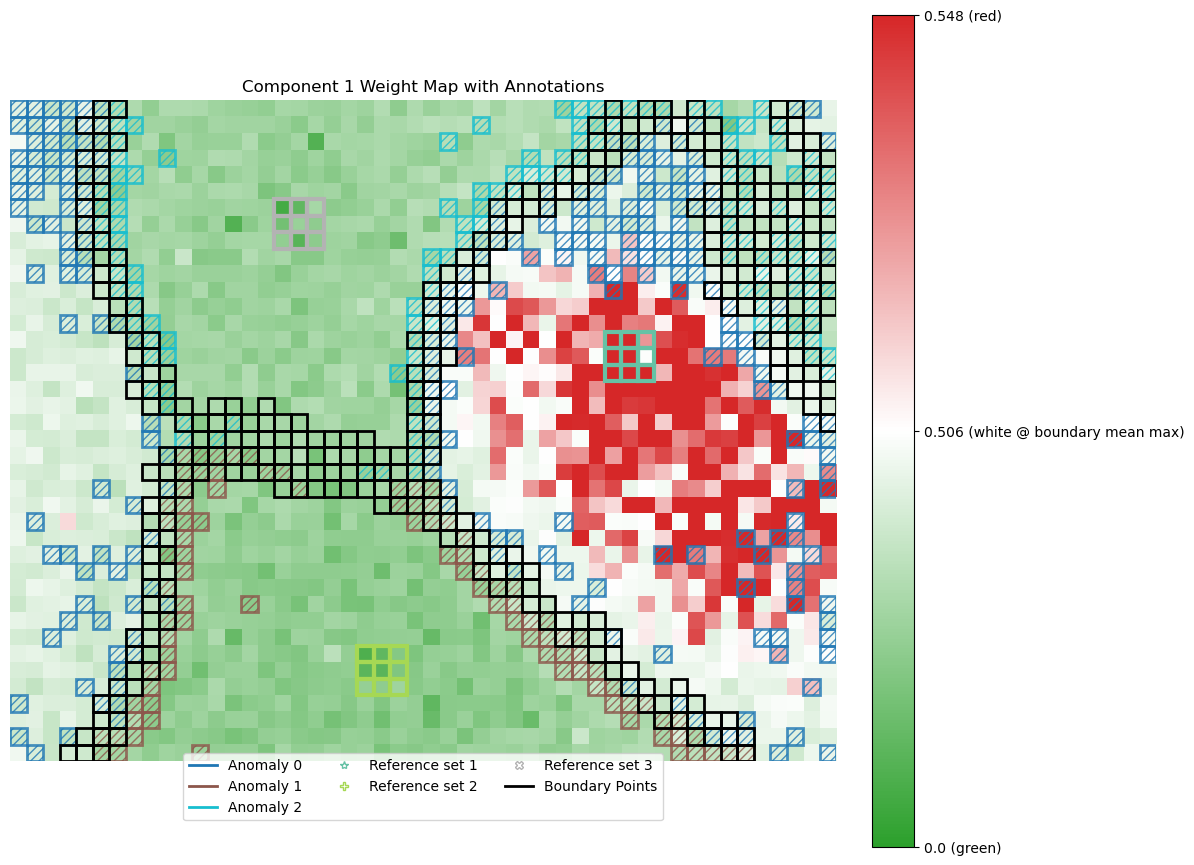

Similarity between anomalies and boundary points:
  Number of anomalies: 469
  Number of boundary points: 348
  Intersection: 194
  Jaccard Index: 0.3114
  Overlap Coefficient: 0.5575


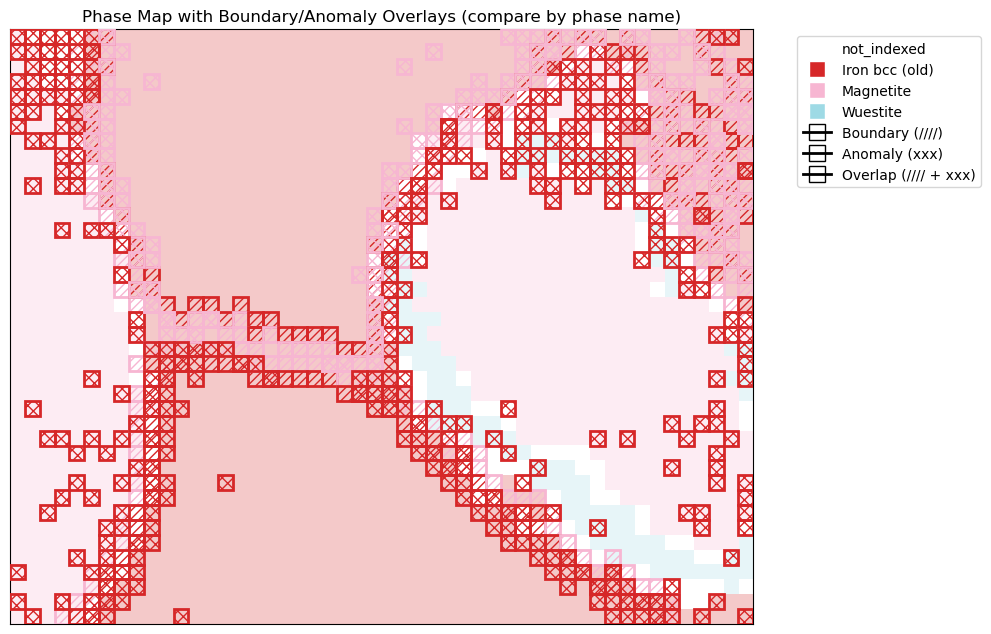

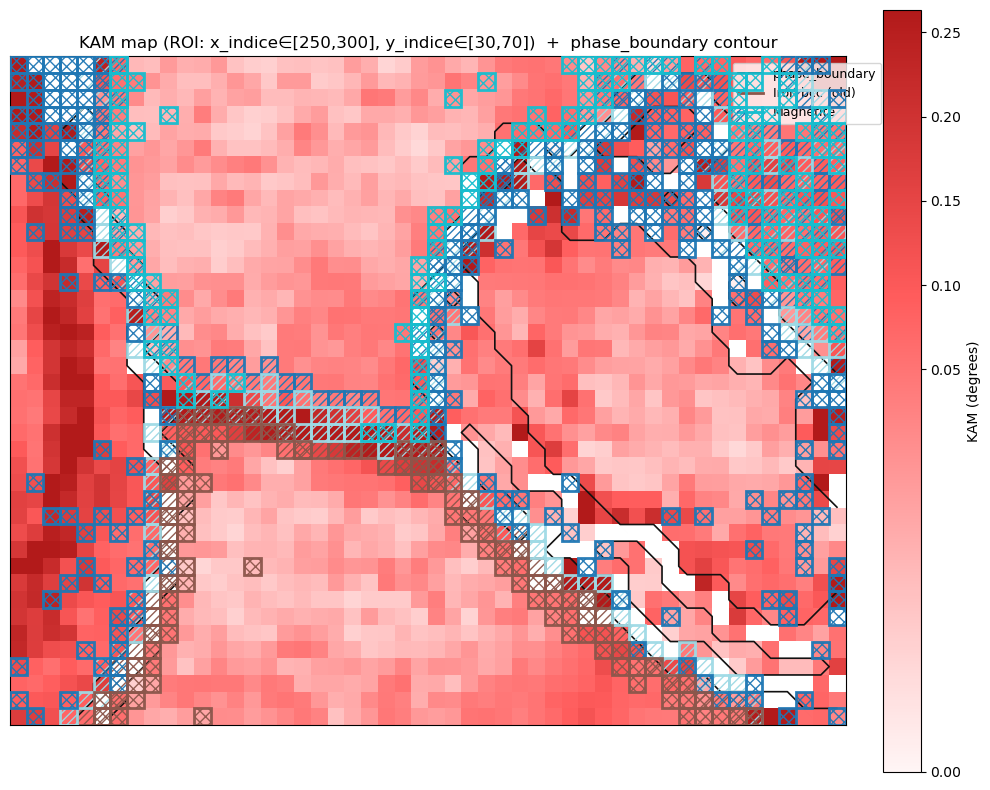

In [ ]:
#=== boundary points are regarded as the points at the edge of clusters (based on the clusertering results of cnmf) ===
from cNMF import detect_boundary_points

boundary_dict = detect_boundary_points(weights1, loc_1, 40, 50, coord_to_label_cnmf1, True)
boundary_pairs = boundary_dict['boundary_locs']
boundary_label_dict = {coord: coord_to_label_cnmf1[coord] 
                 for coord in boundary_pairs if coord in coord_to_label_cnmf1}
jaccard, overlap_coefficient= plot_weight_map_cnmf_with_anomalies(weights1, loc_1, 40, 50, anomalies_coords_label1,ref_pos_list, 0, boundary_pairs)

plot_phase_heatmap(coord_phase_dict, boundary_label_dict, anomalies_coords_label1, phase_labels, cluster_name_map, cluster_name_map, (40,50), roi_xrange_x1, roi_yrange_x1)

plot_kam_with_learning_boundary(df, "phase_boundary", roi_xrange_x1, roi_yrange_x1, boundary_label_dict, anomalies_coords_label1, cluster_name_map, cluster_name_map, (10,8), "KAM", "x_indice", "y_indice")


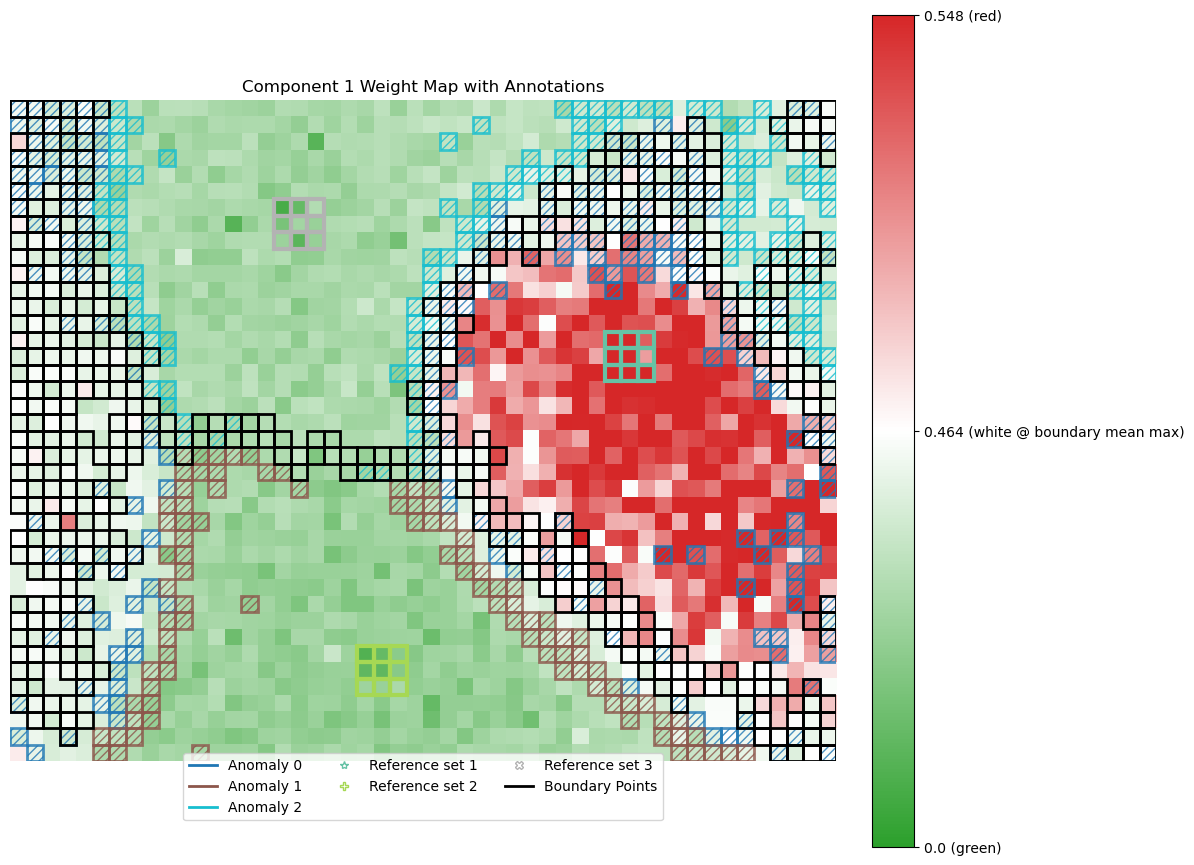

Similarity between anomalies and boundary points:
  Number of anomalies: 469
  Number of boundary points: 476
  Intersection: 173
  Jaccard Index: 0.2241
  Overlap Coefficient: 0.3689


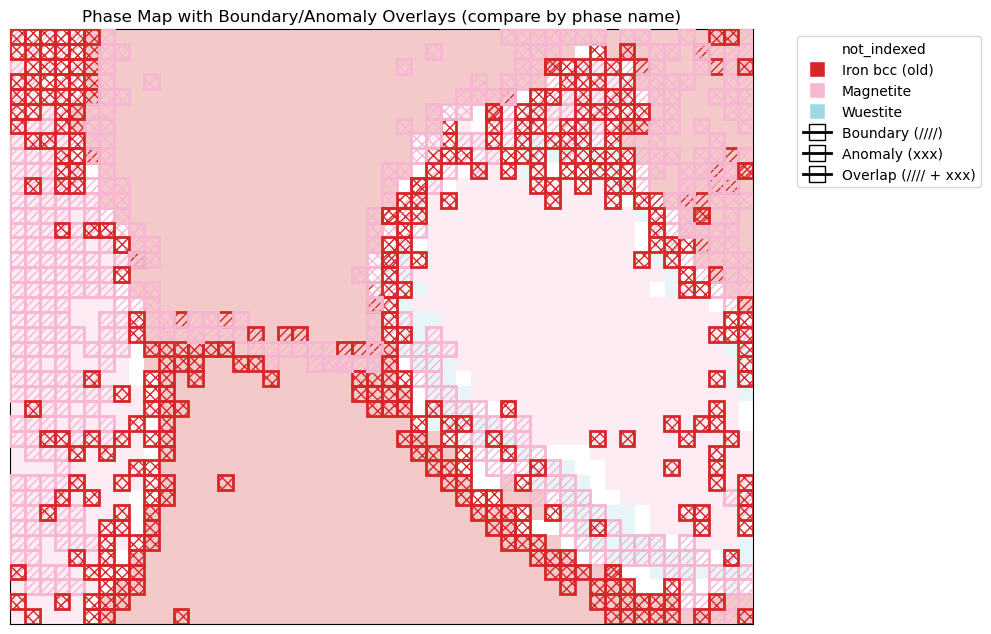

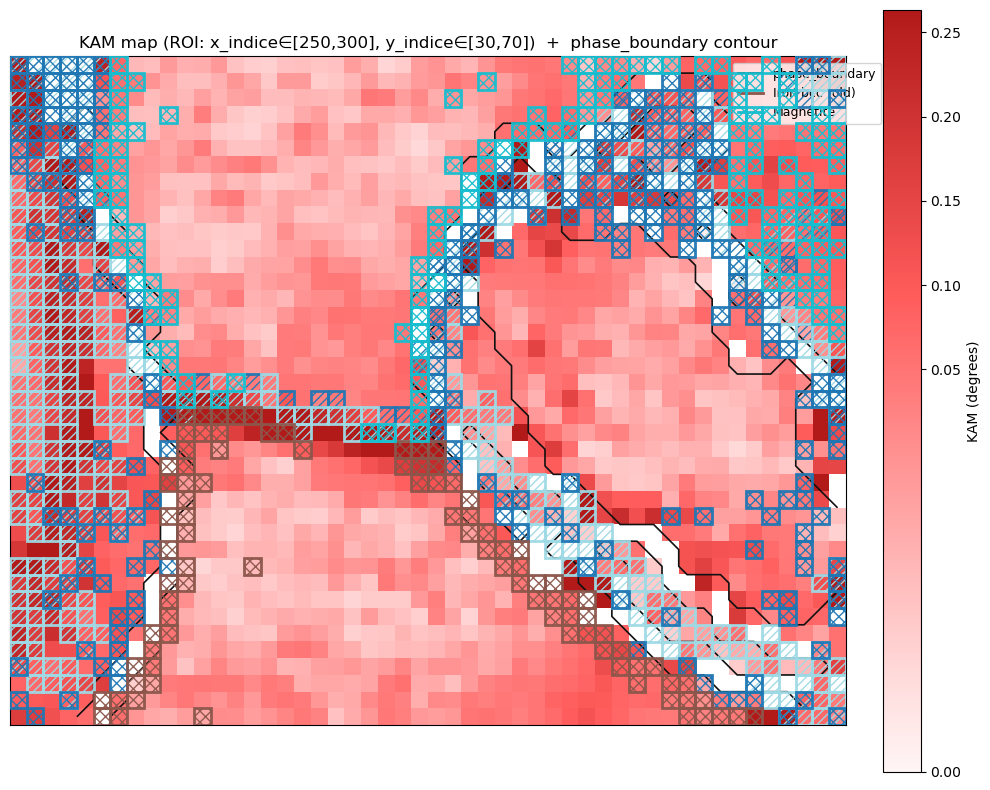

In [19]:
#=== boundary points are regarded as the points which are surrounded by different grain labels based on weights ===
boundary_dict = detect_boundary_points(weights1, loc_1, 40, 50, None, True)
boundary_pairs = boundary_dict['boundary_locs']
boundary_label_dict = {coord: coord_to_label_cnmf1[coord] 
                 for coord in boundary_pairs if coord in coord_to_label_cnmf1}
jaccard, overlap_coefficient= plot_weight_map_cnmf_with_anomalies(weights1, loc_1, 40, 50, anomalies_coords_label1,ref_pos_list, 0, boundary_pairs)

plot_phase_heatmap(coord_phase_dict, boundary_label_dict, anomalies_coords_label1, phase_labels, cluster_name_map, cluster_name_map, (40,50), roi_xrange_x1, roi_yrange_x1)

plot_kam_with_learning_boundary(df, "phase_boundary", roi_xrange_x1, roi_yrange_x1, boundary_label_dict, anomalies_coords_label1, cluster_name_map, cluster_name_map, (10,8), "KAM", "x_indice", "y_indice")


## Shrink the RoI to X3 (20,20)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 1223.90it/s]


[GMM] selection=hybrid -> k=2 | BIC=223698.9 AIC=182582.8 SIL=0.2441


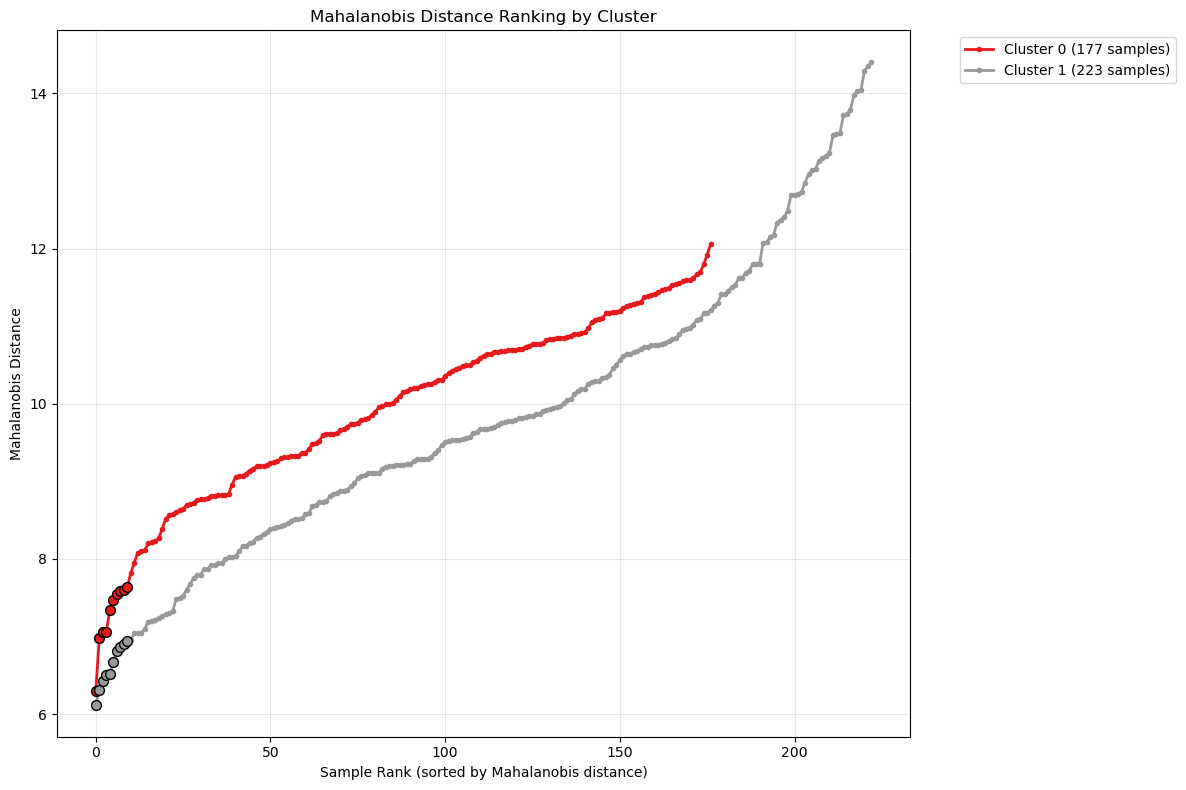

Top samples per cluster:
Cluster 0: 10 samples
  Distance range: 6.3041 - 7.6392
  Coordinates: [[252  51]
 [258  52]
 [254  62]]...

Cluster 1: 10 samples
  Distance range: 6.1235 - 6.9410
  Coordinates: [[264  57]
 [262  69]
 [266  69]]...

Best Reference Windows per Cluster:
Cluster 0:
  Center Location: [252  51]
  Metric Value: 11.3490 (w1=1, w2=1)
  Window Mean Distance: 9.4042
  Window Variance: 1.9448
----------------------------------------
Cluster 1:
  Center Location: [268  62]
  Metric Value: 8.5289 (w1=1, w2=1)
  Window Mean Distance: 7.5445
  Window Variance: 0.9844
----------------------------------------


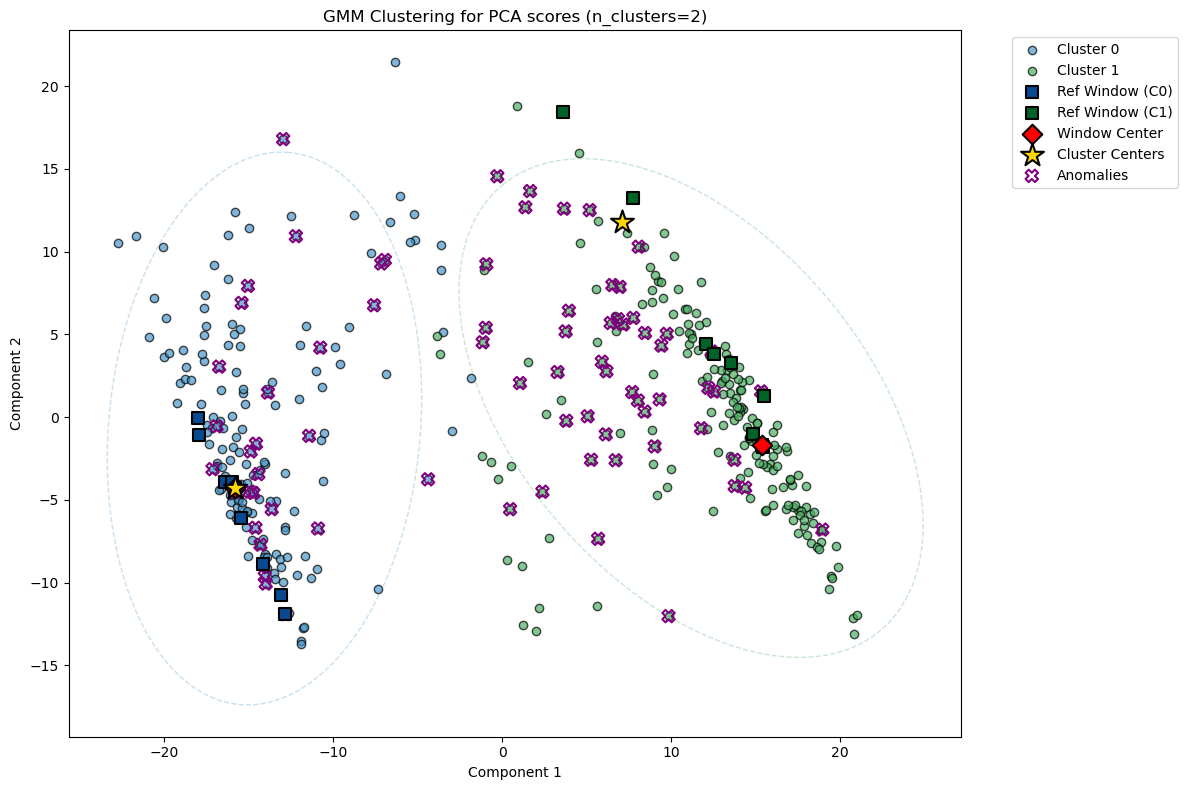

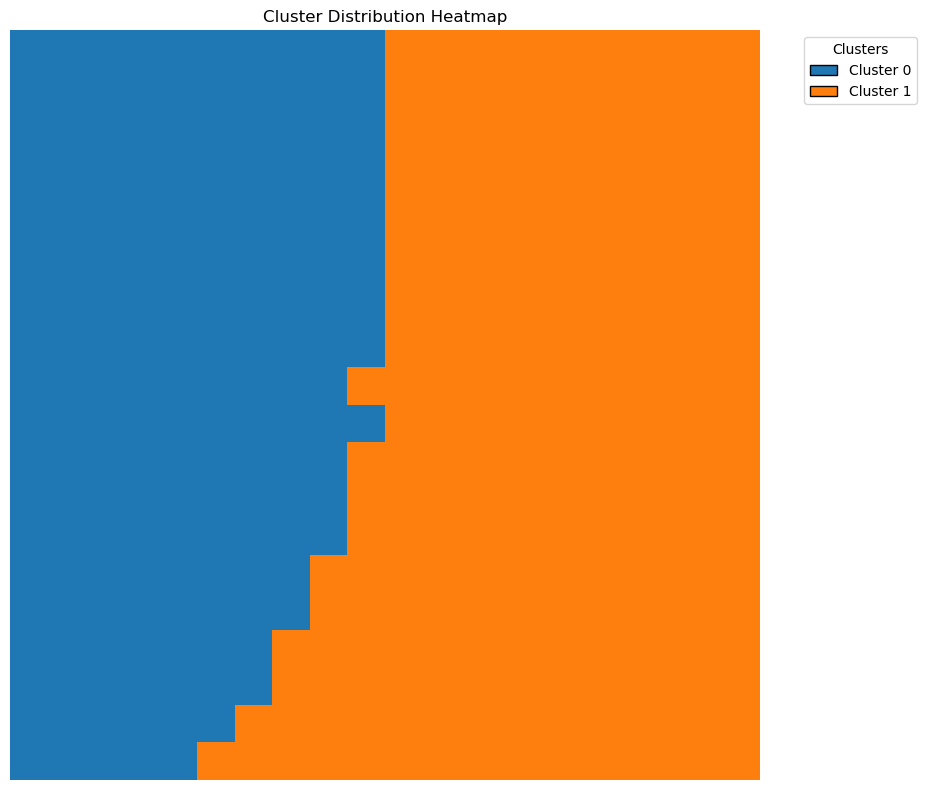

In [25]:
pca_scores3, pca3 = run_PCA(X3, 100 ,height, width,slice_x, slice_y)
gmm_model3, cluster_coords_3, coord_to_label3, cluster_label3, optimal_n, silhouette = gmm_clustering(pca_scores3, loc_3, None, 10)

#anomalies_cluster_pca_scores1, anomalies_cluster_pca_coords1, anomalies_labels_pca1 = detect_anomalies_pca(pca_scores, coord_to_label1, loc_relative)
anomalies_cluster_pca_scores3, anomalies_cluster_pca_coords3, anomalies_coords_label3 = detect_anomalies_pca(pca_scores3, coord_to_label3, loc_3)
centers3, covs3, variations3 = calculate_cluster_metrics(gmm_model3, cluster_label3, pca_scores3)

top_samples_per_cluster= plot_cluster_distances_ranking(gmm_model3, cluster_label3, pca_scores3, loc_3)
best_window = find_best_reference_window(top_samples_per_cluster, cluster_label3, variations3, loc_3)

plot_gmm_clusters(pca_scores3, cluster_label3, optimal_n, variations3, 2, anomalies_cluster_pca_scores3, best_window)

plot_cluster_heatmap(cluster_coords_3,(20,20))

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
         Metric         Value
            ARI      0.877943
            NMI      0.804732
    homogeneity      0.727568
   completeness      0.900205
      v_measure      0.804732
mapped_accuracy          0.94
   mapping_mode Majority-vote
  user_accuracy          None

Cluster-to-Phase Mapping (Majority-vote):
------------------------------------------------------------
 cluster  Samples User mapping Chosen mapping
       0      177            —      Magnetite
       1      223            — Iron bcc (old)

Confusion Matrix (After Mapping):
------------------------------------------------------------
                      Pred: not_indexed  Pred: Iron bcc (old)  Pred: Magnetite
True: not_indexed                     0                     5               16
True: Iron bcc (old)                  0                   218                3
True: Magnetite                       0    

/Users/kikizhang/Phd/Workflow/pycode/microstructural_segmentation/cluster_analysis.py:738: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


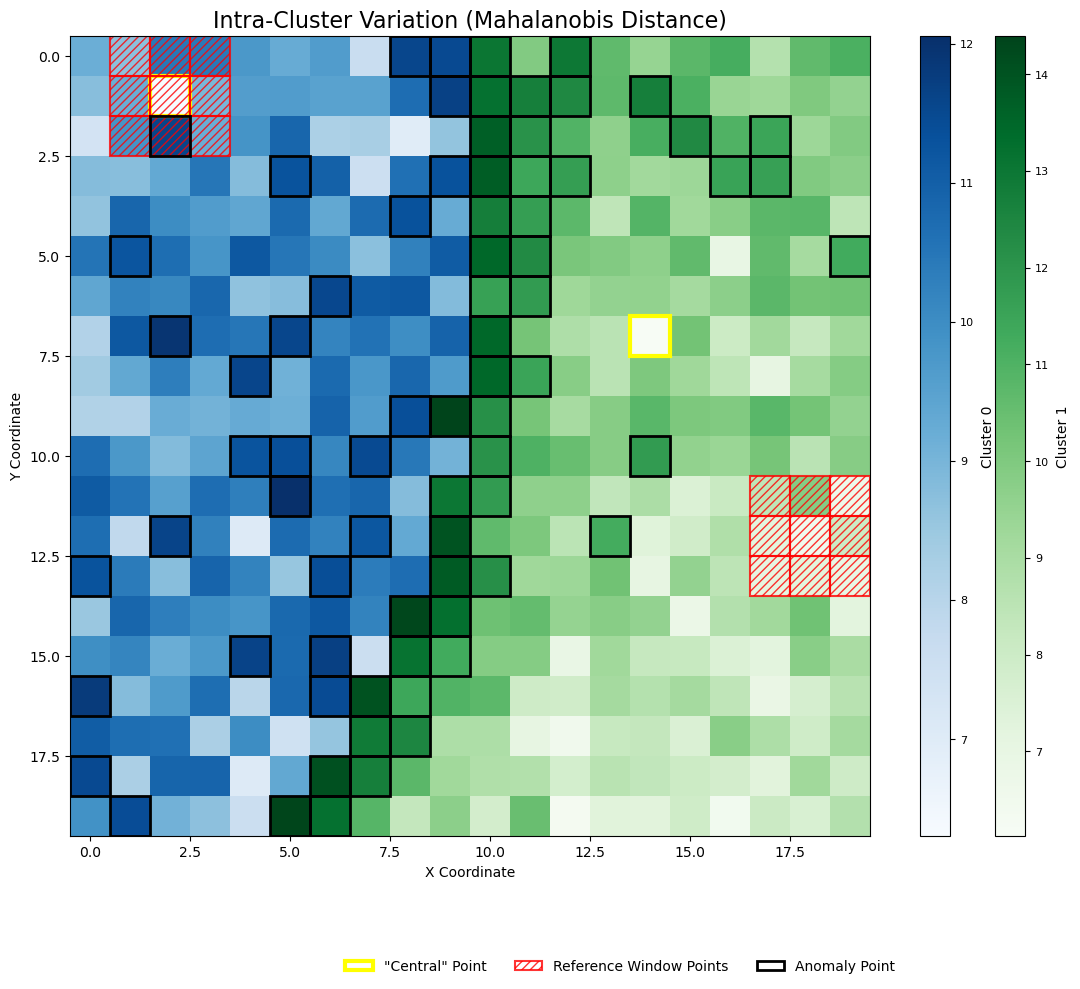

[########################################] | 100% Completed | 107.91 ms


100%|██████████| 2/2 [00:00<00:00, 149.17it/s]

[########################################] | 100% Completed | 105.68 ms



100%|██████████| 2/2 [00:00<00:00, 138.55it/s]


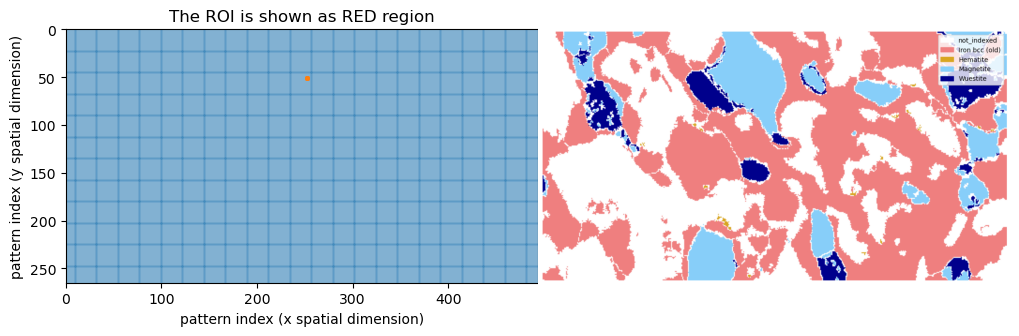

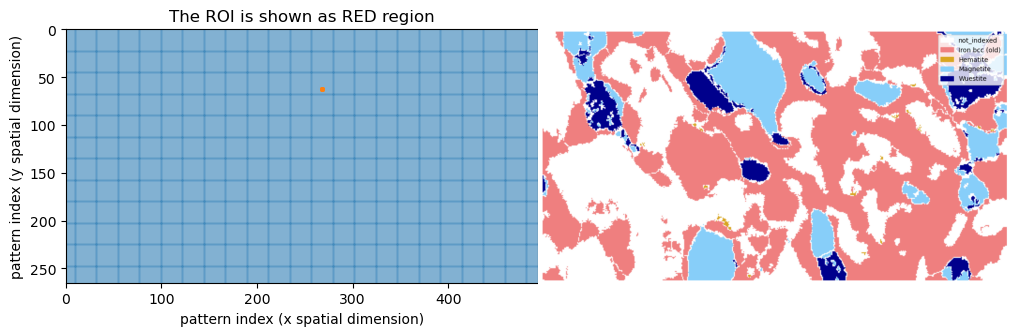

In [26]:
phase_labels = {
    -1: 'not_indexed',
     1: 'Iron bcc (old)',
     3: 'Hematite',
     4: 'Magnetite',
     5: 'Wuestite'
}
evaluate_results = evaluate_clustering_metrics(coord_phase_dict, coord_to_label3, phase_labels, None, True, "majority")
mapped_phaseid= evaluate_results['detailed_results']['mapped_phaseid']
plot_intra_cluster_variation_map(loc_3, variations3, cluster_label3, (20,20), None, None, anomalies_cluster_pca_coords3, None, None, best_window)

R_list = []
ranges_list = []   # [(x_range, y_range, center_loc, key), ...]
ref_pos_list = []

# Sorted iteration for reproducibility
for key in sorted(best_window.keys(), key=lambda k: int(k)):
    entry = best_window[key]
    cx, cy = map(int, entry['center_loc'])  # center_loc: array([x, y])

    x0, x1 = cx - 1, cx + 1
    y0, y1 = cy - 1, cy + 1

    
    x_range = (x0, x1)
    y_range = (y0, y1)

    R, ref_pos = set_component(x_range, y_range, path, grid, path_to_phase_map)

    R_list.append(R)
    ref_pos_list.append(ref_pos)
    ranges_list.append((x_range, y_range, (cx, cy), int(key)))

# Build final components object
components = get_components(R_list, 3, None, height, width, slice_x, slice_y)

100%|██████████| 2/2 [00:00<00:00, 803.66it/s]


100%|██████████| 2/2 [00:00<00:00, 1302.98it/s]


Max absolute value of (weight sum-1): 0.24886178970336914 (In row 209)
Min absolute value of (weight sum-1): 0.0537874698638916 (In row 378)
[GMM] fixed k=2 | SIL=0.6724


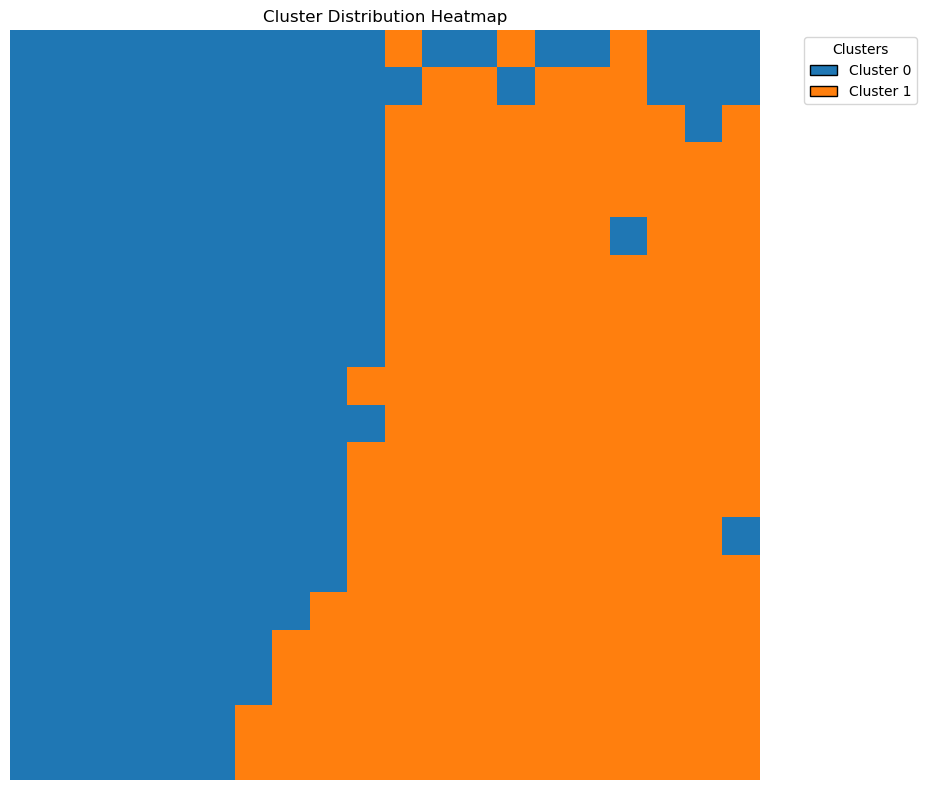

Clustering Evaluation Results

Evaluation Metrics:
------------------------------------------------------------
         Metric         Value
            ARI      0.741097
            NMI      0.668173
    homogeneity      0.606533
   completeness      0.743759
      v_measure      0.668173
mapped_accuracy        0.9025
   mapping_mode Majority-vote
  user_accuracy          None

Cluster-to-Phase Mapping (Majority-vote):
------------------------------------------------------------
 cluster  Samples User mapping Chosen mapping
       0      194            —      Magnetite
       1      206            — Iron bcc (old)

Confusion Matrix (After Mapping):
------------------------------------------------------------
                      Pred: not_indexed  Pred: Iron bcc (old)  Pred: Magnetite
True: not_indexed                     0                     3               18
True: Iron bcc (old)                  0                   203               18
True: Magnetite                       0    

In [32]:
# run cNMF
weights3,mse,r_square = run_cNMF(X3, components, height, width, slice_x, slice_y)

# Sum of all weights
row_sums_minus_3 = weights3.sum(axis=1) - 1
abs_values = np.abs(row_sums_minus_3)

# Min and Max for the sum -1
max_abs = np.max(abs_values)
min_abs = np.min(abs_values)
max_abs_index = np.argmax(abs_values)
min_abs_index = np.argmin(abs_values)

print(f"Max absolute value of (weight sum-1): {max_abs} (In row {max_abs_index})")
print(f"Min absolute value of (weight sum-1): {min_abs} (In row {min_abs_index})")


gmm_model_cnmf3, cluster_coords_cnmf3, coord_to_label_cnmf3, cluster_labels_cnmf3, optimal_n, silhouette = gmm_clustering(weights3, loc_3, 2, 10)

plot_cluster_heatmap(cluster_coords_cnmf3,(20,20))

evaluate_results = evaluate_clustering_metrics(coord_phase_dict, coord_to_label_cnmf3, phase_labels, None, True)
cluster_name_map = evaluate_results['mapping_names']

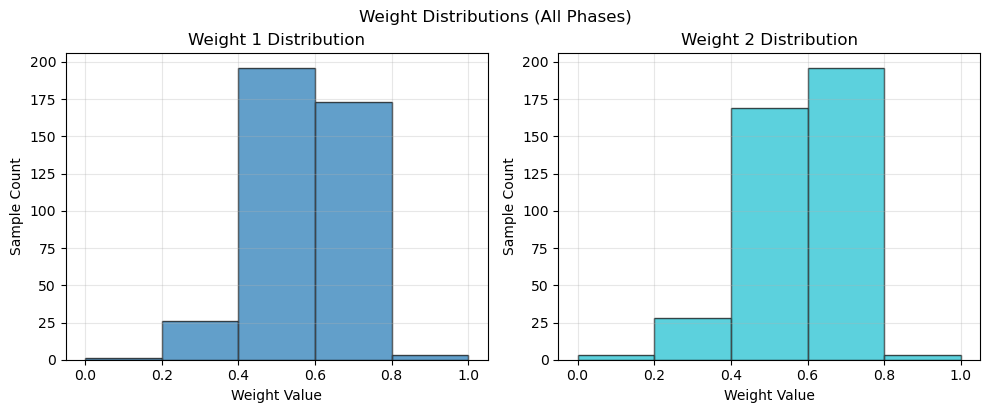

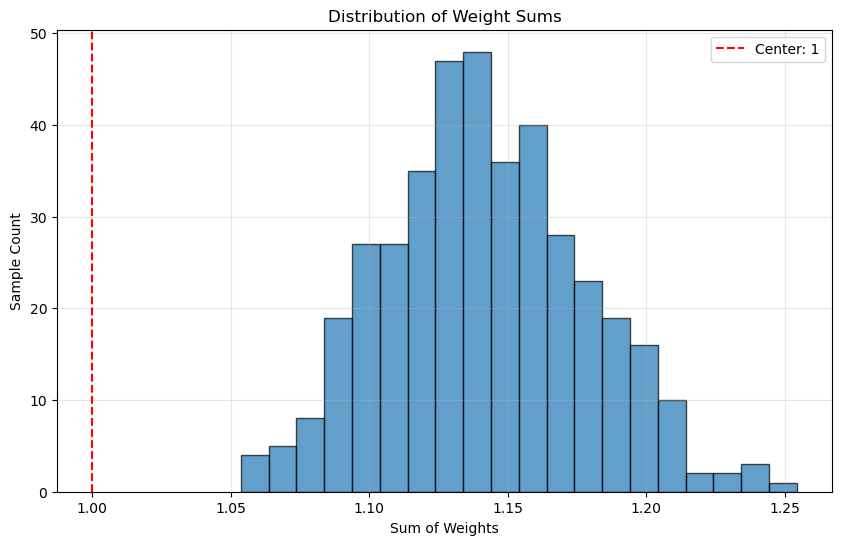

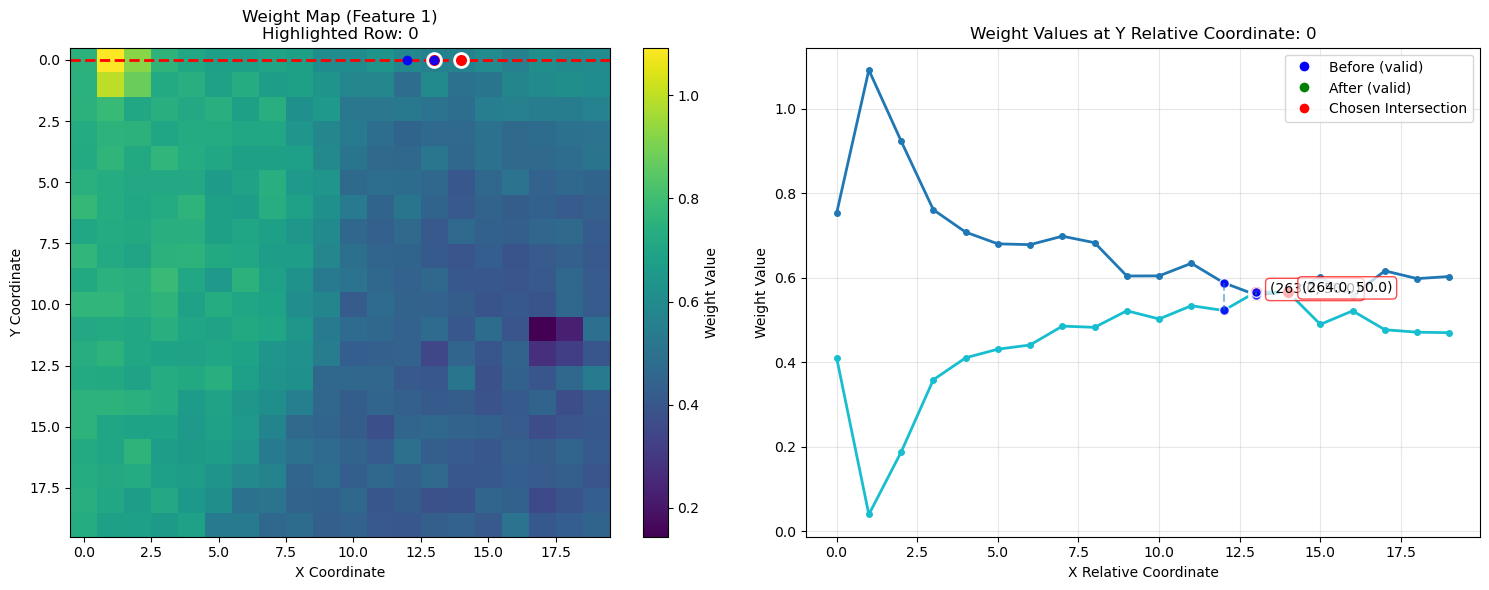

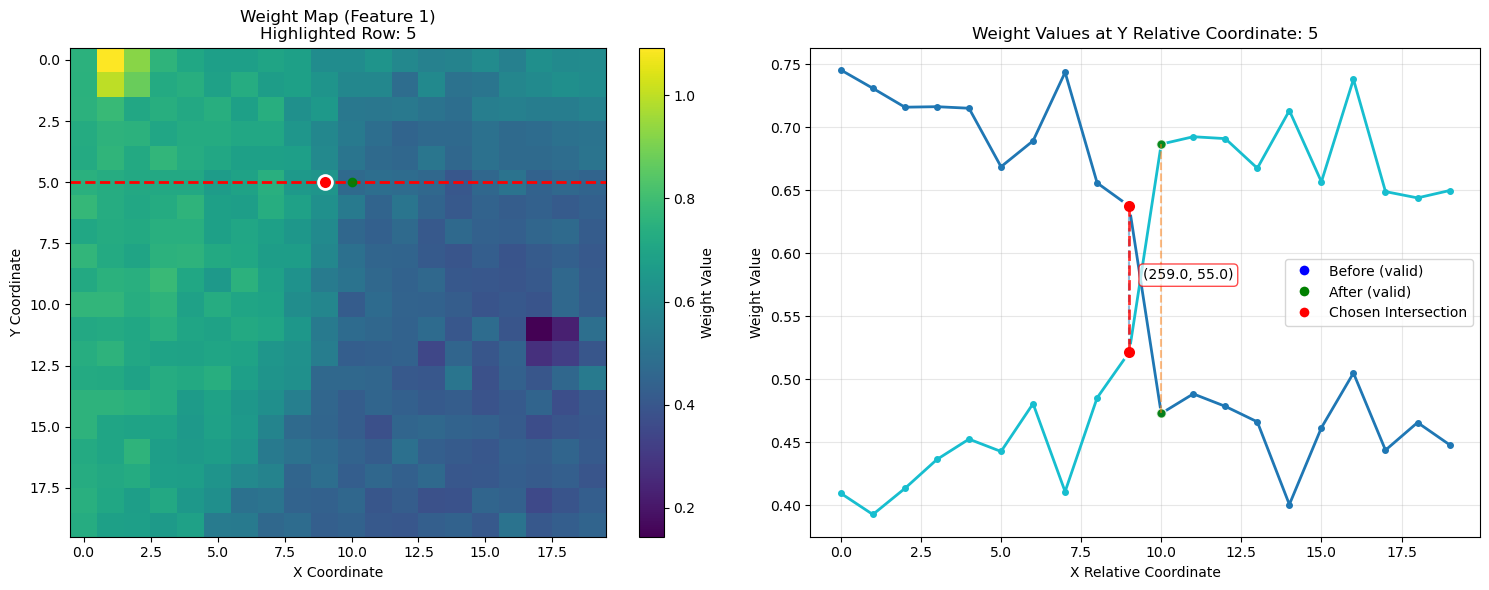

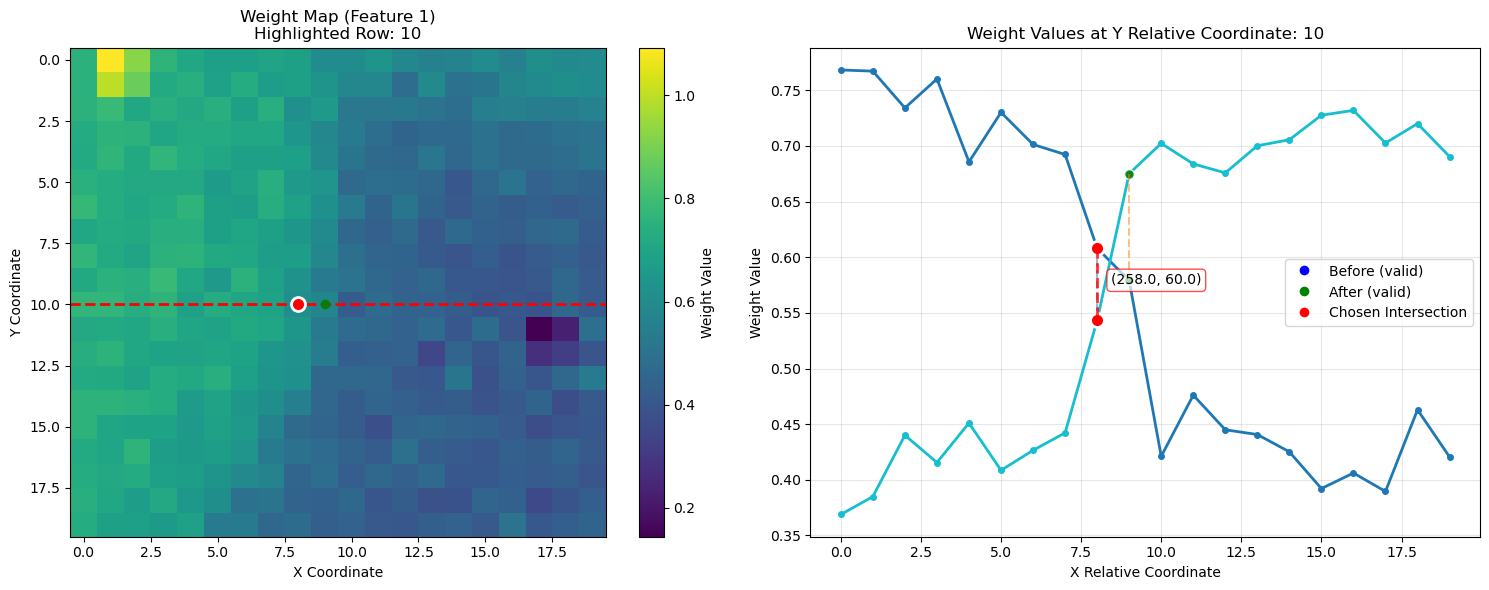

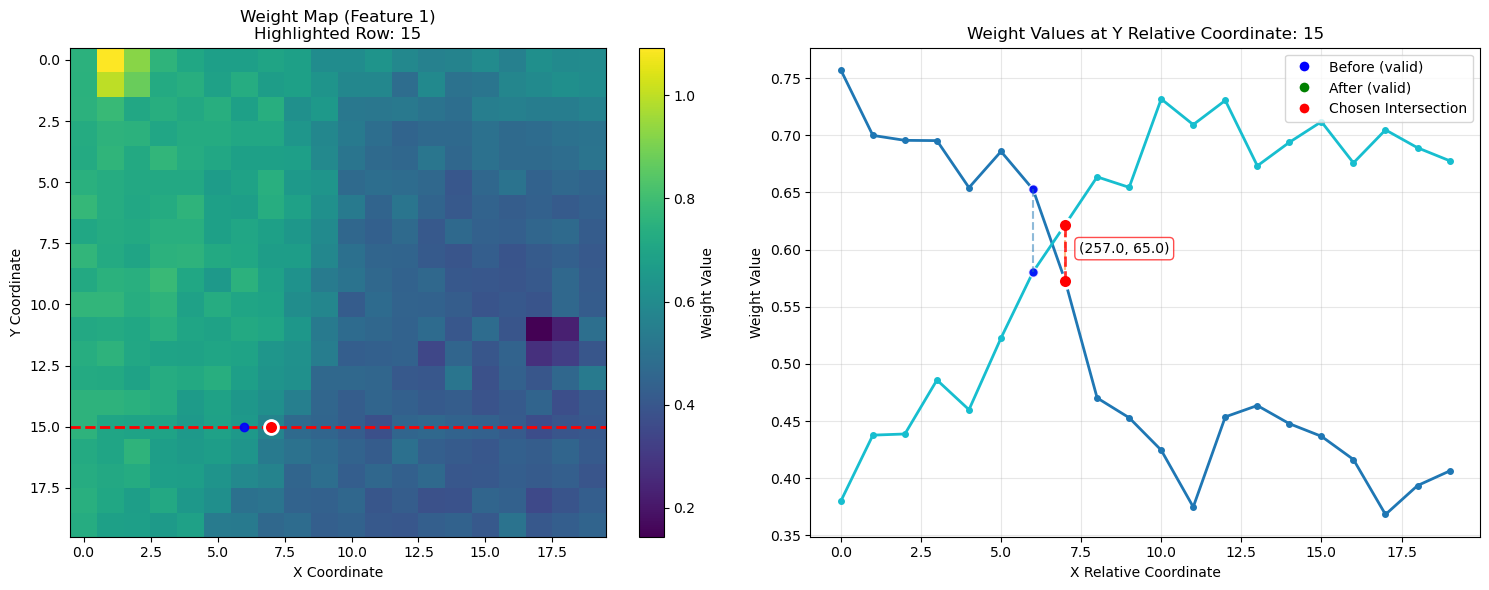

In [28]:
plot_weight_histograms(weights3, loc_3, coord_to_label_cnmf3, cluster_name_map, None, None)
plot_weight_sum_histogram(weights3, 1, 20)

weight_maps = get_weight_map(weights3, loc_3, 20, 20)
intersections1, fig1 = get_intersection_points_y(weight_maps, 0, roi_xrange_x3[0], roi_yrange_x3[0], 20, 20)
intersections2, fig2 = get_intersection_points_y(weight_maps, 5, roi_xrange_x3[0], roi_yrange_x3[0], 20, 20)
intersections3, fig3 = get_intersection_points_y(weight_maps, 10, roi_xrange_x3[0], roi_yrange_x3[0], 20, 20)
intersections4, fig4 = get_intersection_points_y(weight_maps, 15, roi_xrange_x3[0], roi_yrange_x3[0], 20, 20)

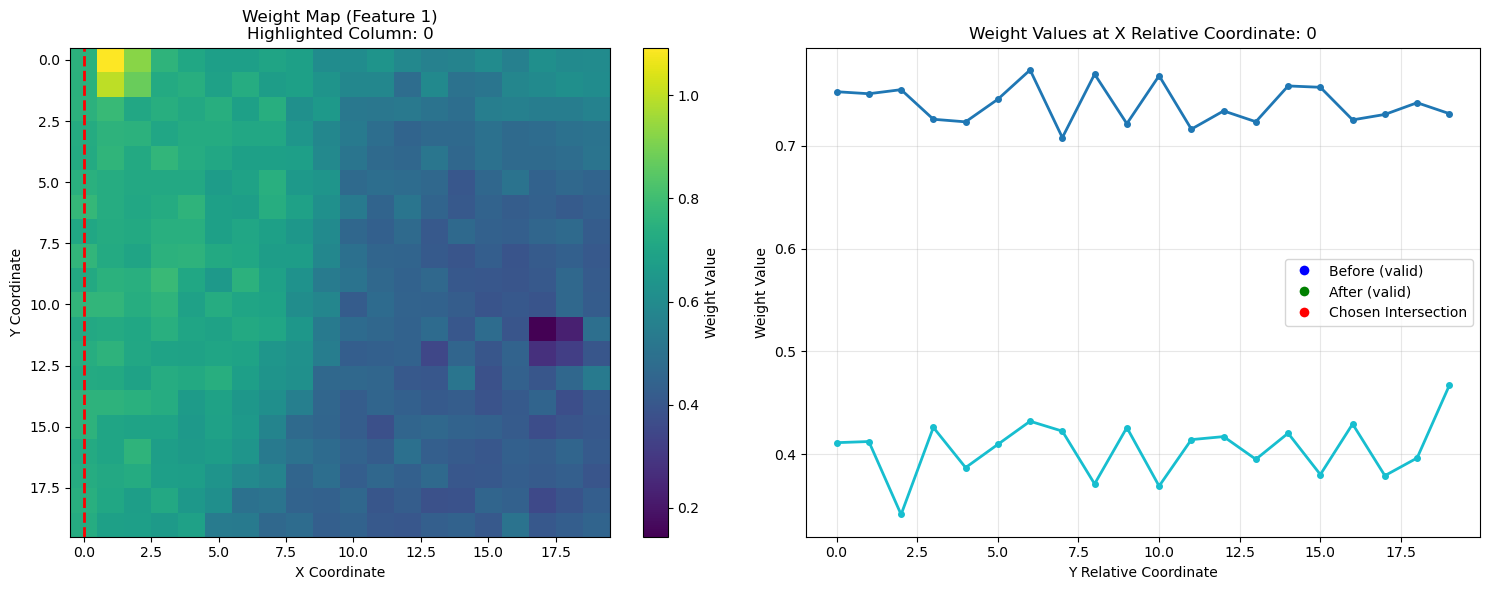

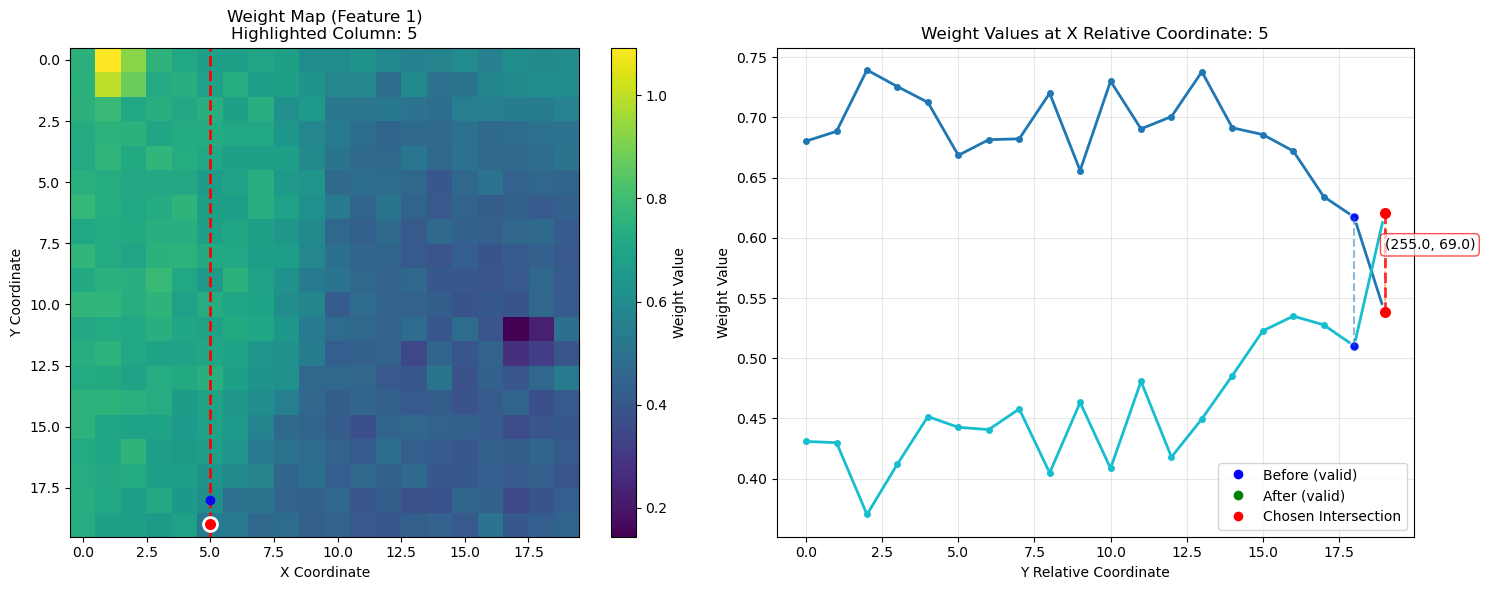

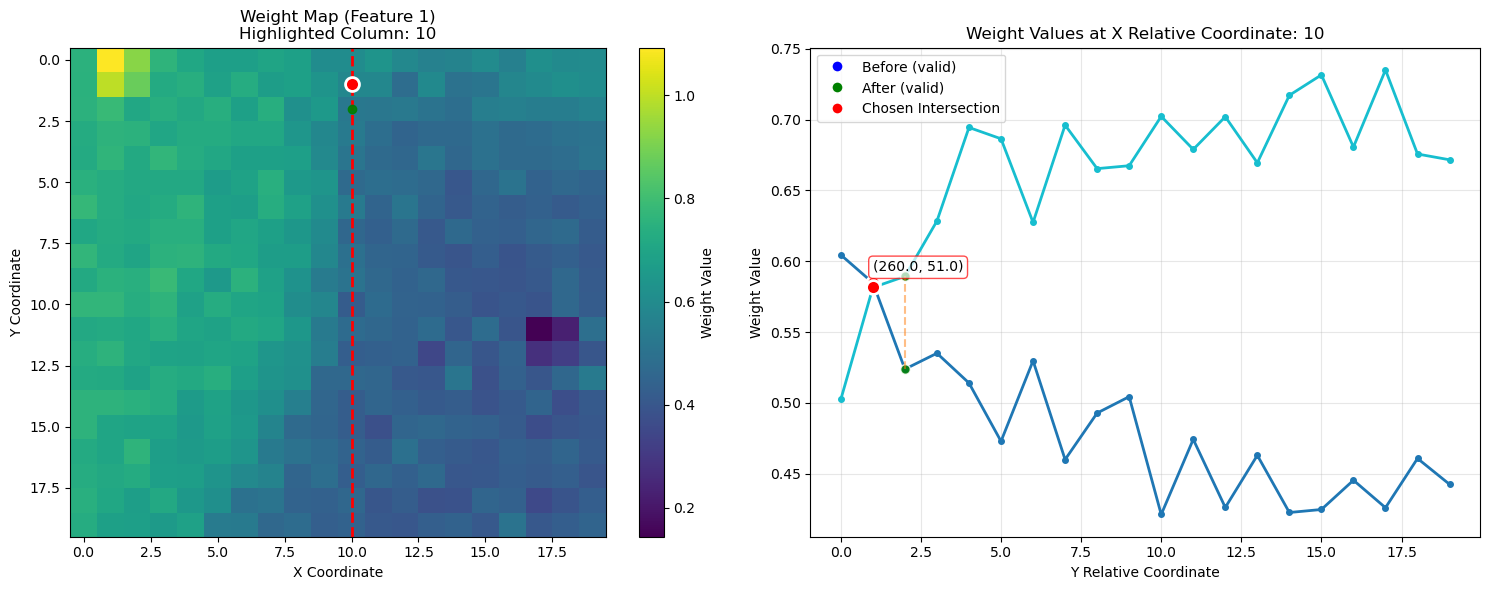

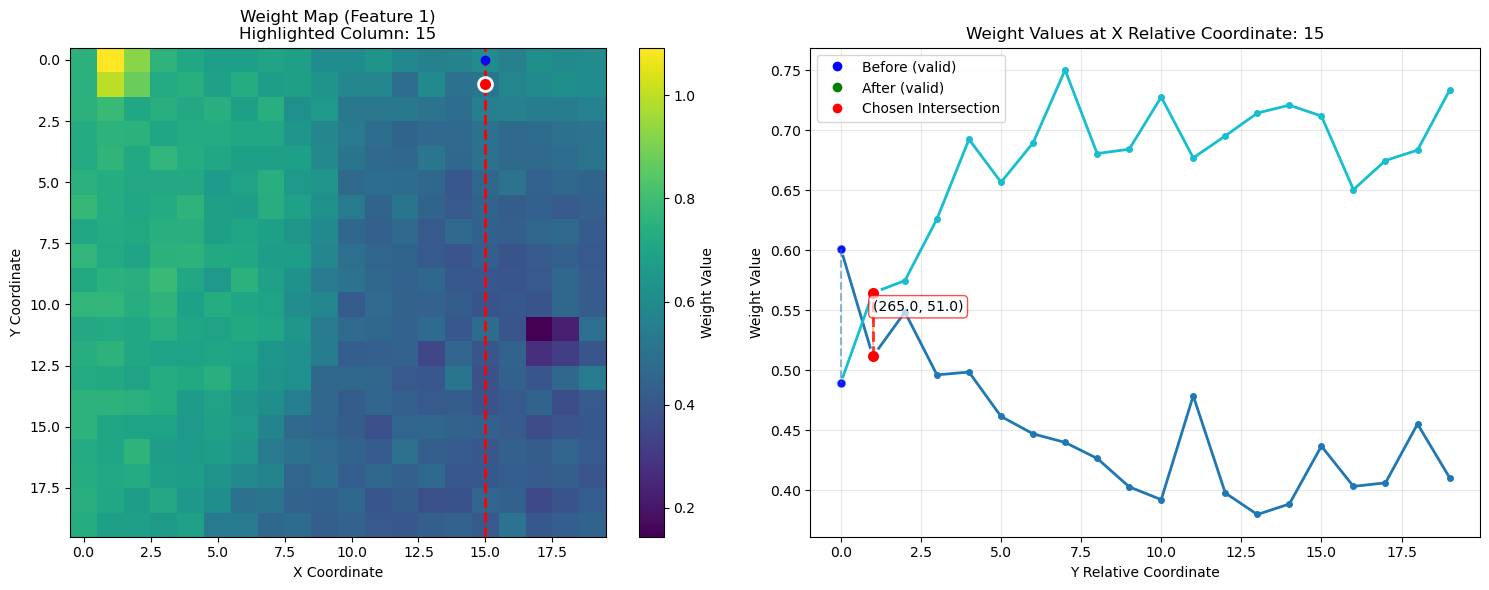

In [29]:
intersections1, fig1 = get_intersection_points_x(weight_maps, 0, roi_xrange_x3[0], roi_yrange_x3[0], 20, 20)
intersections2, fig2 = get_intersection_points_x(weight_maps, 5, roi_xrange_x3[0], roi_yrange_x3[0], 20, 20)
intersections3, fig3 = get_intersection_points_x(weight_maps, 10, roi_xrange_x3[0], roi_yrange_x3[0], 20, 20)
intersections4, fig4 = get_intersection_points_x(weight_maps, 15, roi_xrange_x3[0], roi_yrange_x3[0], 20, 20)

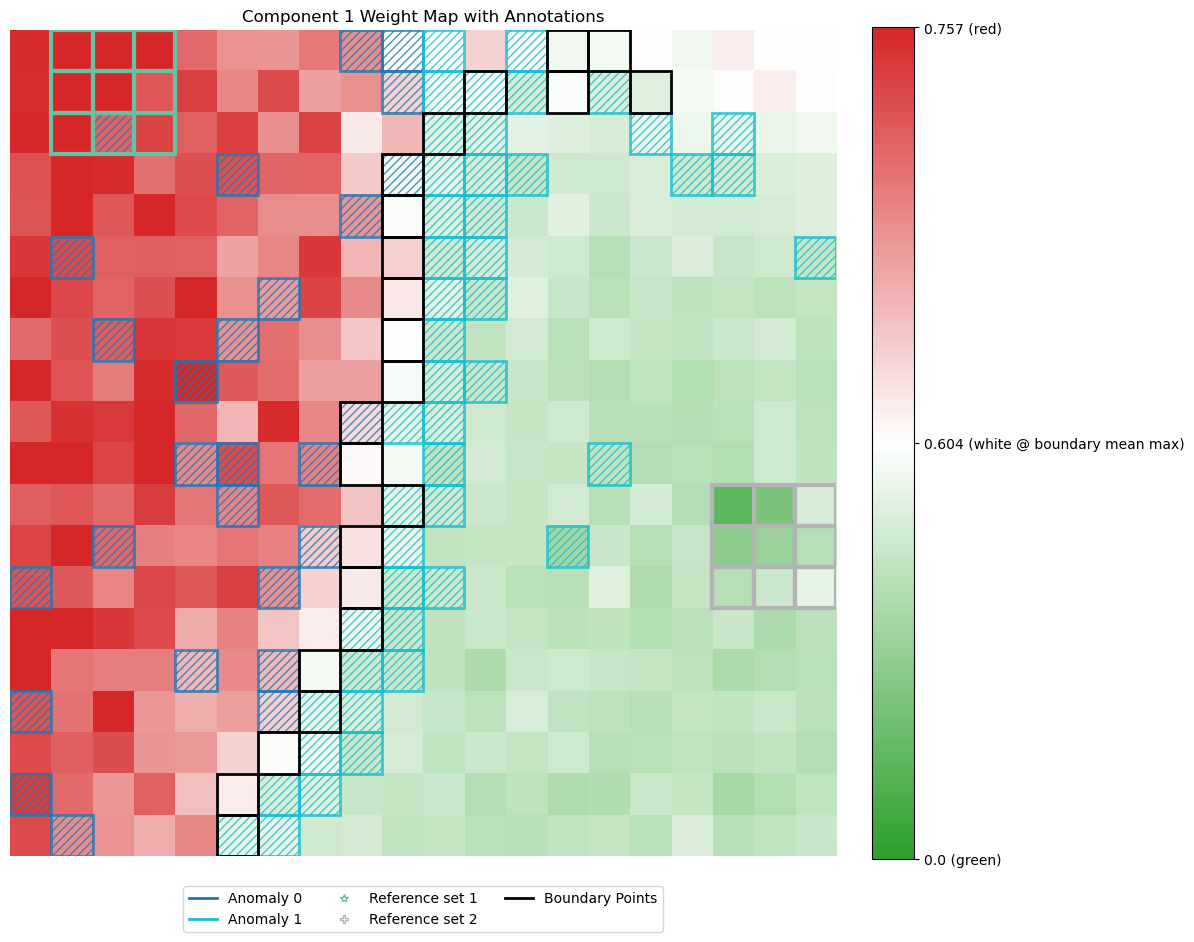

Similarity between anomalies and boundary points:
  Number of anomalies: 74
  Number of boundary points: 23
  Intersection: 8
  Jaccard Index: 0.0899
  Overlap Coefficient: 0.3478


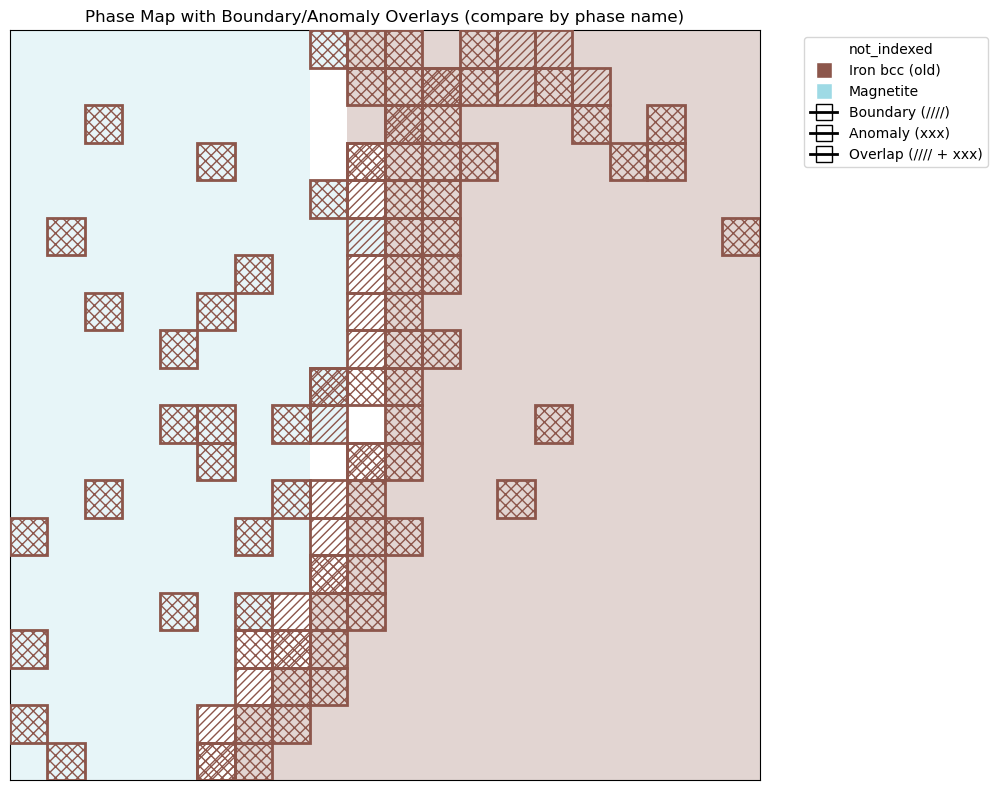

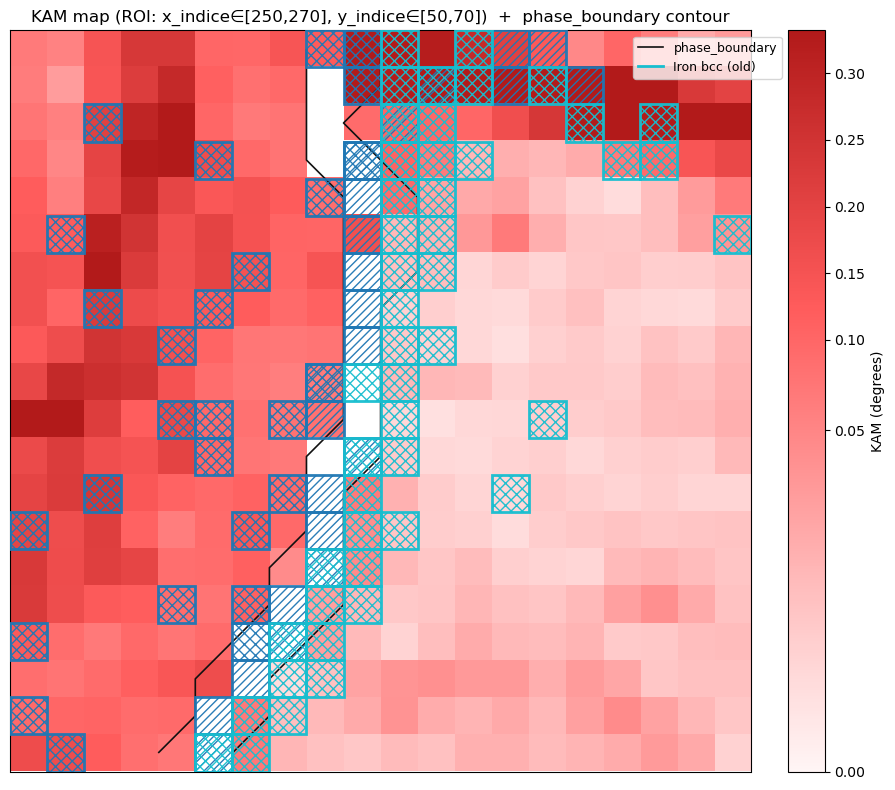

In [31]:
all_intersections = find_all_intersections_xy(weights3, loc_3, 20, 20)

#=== boundary detected both in the direction x and y ====

boundary_pairs = set([(point[0], point[1]) for point in all_intersections['y_based']])
boundary_label_dict = {coord: coord_to_label_cnmf3[coord] 
                 for coord in boundary_pairs if coord in coord_to_label_cnmf3}
jaccard, overlap_coefficient= plot_weight_map_cnmf_with_anomalies(weights3, loc_3, 20, 20, anomalies_coords_label3,ref_pos_list, 0, boundary_pairs)

plot_phase_heatmap(coord_phase_dict, boundary_label_dict, anomalies_coords_label3, phase_labels, cluster_name_map, cluster_name_map, (20,20), roi_xrange_x3, roi_yrange_x3)

plot_kam_with_learning_boundary(df, "phase_boundary", roi_xrange_x3, roi_yrange_x3, boundary_label_dict, anomalies_coords_label3, cluster_name_map, cluster_name_map, (10,8), "KAM", "x_indice", "y_indice")

#plot_cnmf_weights_projected(weights3, loc_3, cluster_label3, (0,1), '2d', boundary_pairs, ref_pos_list, anomalies_coords_label3)